# Probabilistic Linear Inference

## The Continuous Problem

We consider the problem of inferring an unknown model parameter $m$ from noisy observations $\mathbf{\tilde{d}}$, where $m$ lies in a separable Hilbert space $\mathcal{M}$ and $\mathbf{\tilde{d}} \in \mathcal{D}$, a finite‑dimensional Euclidean data space $\mathcal{D} \cong \mathbb{R}^{N_d}$ ($N_d \in \mathbb{N}$ is the number of data).

The relationship between the model and the data is described by a forward operator:
$$
G: \mathcal{M} \to \mathcal{D}, \quad [G(m)]_i = \langle K_i, m \rangle_{\mathcal{M}}
$$
assumed to be linear and bounded. The observed data is modeled as:
$$
\mathbf{\tilde{d}} = G(m) + \bm{\eta},
$$
where $\bm{\eta} \sim \mathcal{N}(0, \mathbf{C}_{\mathcal{D}})$ represents additive Gaussian noise with known symmetric positive‑definite covariance matrix $\mathbf{C}_{\mathcal{D}} \in \mathbb{R}^{N_d \times N_d}$.

To regularize this ill‑posed inverse problem, we adopt a Bayesian framework. We model the unknown $m$ as a random variable and assign a Gaussian prior:
$$
m \sim \mu_{\mathcal{M}}^0 := \mathcal{N}(m_0, C_0),
$$
where $m_0 \in \mathcal{M}$ is the prior mean, and $C_0: \mathcal{M} \to \mathcal{M}$ is a symmetric, positive‑definite trace‑class covariance operator.


**Gaussian measure in terms of $C_0$**  
Under this formulation the Gaussian prior can be equivalently written via its Karhunen–Loève expansion: if $\{\varphi_k\}$ are eigenfunctions of $C_0$ with eigenvalues $\{\lambda_k\}$, then
$$
m = m_0 + \sum_{k=1}^\infty \sqrt{\lambda_k} \,\bm{\xi}_k\,\varphi_k,
\qquad
\bm{\xi}_k \overset{i.i.d.}{\sim} \mathcal{N}(0,1).
$$
Thus $C_0$ controls the decay of $\lambda_k$ and hence the regularity of samples from $\mu_{\mathcal{M}}^0$.

The goal of Bayesian inversion is to compute or characterize the posterior distribution $\mu_{\mathcal{M}}^{\mathbf{\tilde{d}}}$ of $m$ conditioned on the observed data $\mathbf{\tilde{d}}$. According to Bayes’ theorem (in the infinite‑dimensional setting), the posterior is given formally by:
$$
\frac{d\mu_{\mathcal{M}}^{\mathbf{\tilde{d}}}}{d\mu_{\mathcal{M}}^0}(m) \;\propto\; \exp\!\left[-\tfrac12\,\|G(m)-\mathbf{\tilde{d}}\|_{\mathbf{C}^{-1}_{\mathcal{D}}}^2\right],
$$
where the data‐misfit norm is
$$
\|\mathbf{v}\|_{\mathbf{C}^{-1}_{\mathcal{D}}}^2 := \mathbf{v}^\top\,\mathbf{C}_{\mathcal{D}}^{-1}\,\mathbf{v}.
$$

Bayesian inference takes this a step further and asks for a specific property of the true model. Let 
$$
\mathcal{T} \colon \mathcal{M} \to \mathcal{P}, \quad [\mathcal{T}(m)]_i = \langle T_i, m \rangle_{\mathcal{M}}
$$
be a linear and bounded mapping that takes in a model and outputs a finite number of real scalars that represent some local or global property of the model, such as a global average, a local average, a local gradient average, a Fourier basis coefficient, etc. $T_i \in \mathcal{M}$ are the target kernels. The property space $\mathcal{P}$ is a finite dimensional Hilbert space equivalent to $\mathbb{R}^{N_p}$ where $N_p \in \mathbb{N}$ is the number of "properties" to be sought. By pushing the infinite-dimensional posterior measure $\mu_{\mathcal{M}}^{\mathbf{\tilde{d}}}$ through the property mapping $\mathcal{T}$ we obtain the (Gaussian) property measure 
$$
\mu_{\mathcal{P}} = \mathcal{T}_*\mu_{\mathcal{M}}^{\mathbf{\tilde{d}}}
$$

## Continuous Solution

Using a Bayesian update we obtain the posterior measure on the model space $\mu_{\mathcal{M}}^{\mathbf{\tilde{d}}} = \mathcal{N}(\tilde{m}, C_{\mathcal{M}})$ where:
$$
\boxed{
C_{\mathcal{M}} = \left( G^* \mathbf{C}_{\mathcal{D}}^{-1} G + C_0^{-1} \right)^{-1}, \quad
\tilde{m} = C_{\mathcal{M}} \left( G^* \mathbf{C}_{\mathcal{D}}^{-1} \mathbf{\tilde{d}} + C_0^{-1}m_0 \right).
}
$$

Then we can obtain the property measure from the model posterior $\mu_{\mathcal{P}} = \mathcal{N}(\mathbf{\tilde{p}}, \mathbf{C}_{\mathcal{P}})$:
$$
\boxed{
\mathbf{\tilde{p}} = \mathcal{T}(\tilde{m}), \quad \mathbf{C}_{\mathcal{P}} = \mathcal{T} C_{\mathcal{M}} \mathcal{T}^*.
}
$$


### Importing the necessary packages

In [1]:
from pygeoinf.interval.function_providers import NormalModesProvider, BumpFunctionProvider, NullFunctionProvider
from pygeoinf.interval.interval_domain import IntervalDomain
from pygeoinf.interval import Lebesgue, LebesgueSpaceDirectSum
from pygeoinf.hilbert_space import EuclideanSpace
from pygeoinf.interval.operators import SOLAOperator
from pygeoinf.interval.functions import Function
from pygeoinf.gaussian_measure import GaussianMeasure
import matplotlib.pyplot as plt
from pygeoinf import RowLinearOperator
import numpy as np
from pygeoinf.interval.boundary_conditions import BoundaryConditions
from pygeoinf.interval.operators import InverseLaplacian, Laplacian, BesselSobolevInverse
from pygeoinf.forward_problem import LinearForwardProblem
from pygeoinf.linear_bayesian import LinearBayesianInference
from pygeoinf.linear_solvers import CholeskySolver
import seaborn as sns
# Set-up folder for saving figures
import os
figures_folder = 'pli_multiple_figures'
if not os.path.exists(figures_folder):
    os.makedirs(figures_folder)

## Configuration

Control the inference workflow with the flag below.

In [2]:
# =============================================================================
# CONFIGURATION FLAGS
# =============================================================================

# Set to True to compute and visualize the model posterior
# Set to False to skip model posterior and go directly to property posterior
COMPUTE_MODEL_POSTERIOR = False

print(f"Configuration:")
print(f"  COMPUTE_MODEL_POSTERIOR = {COMPUTE_MODEL_POSTERIOR}")
if COMPUTE_MODEL_POSTERIOR:
    print("  → Will compute model posterior, then push to property space")
else:
    print("  → Will skip model posterior and compute property posterior directly")
    print("  → Expected speedup: ~4-5x faster")

Configuration:
  COMPUTE_MODEL_POSTERIOR = False
  → Will skip model posterior and compute property posterior directly
  → Expected speedup: ~4-5x faster


## Creating the spaces

We first create the function domain as an interval. The model space will be an $L^2$ space with $N$ basis function of type fourier. 

In [3]:
# Create a function domain and spaces
function_domain = IntervalDomain(0, 1)

# We create a model space for vp and another for vs
N = 100  # number of basis functions
M_vp = Lebesgue(N, function_domain, basis=None)  # model space
M_vs = Lebesgue(N, function_domain, basis=None)  # model space
# And we take their direct sum
M = LebesgueSpaceDirectSum([M_vp, M_vs])
N_d = 50 # number of data points
D = EuclideanSpace(N_d) # data space
N_p = 20 # number of property points
P = EuclideanSpace(N_p) # property space

## Create mappings

In [4]:
# Create forward and property mappings
width = 0.2 # width of the bump target functions
centers = np.linspace(function_domain.a + width / 2, function_domain.b - width / 2, N_p) # centers of the bumps
# Create a normal modes provider for the forward operator
# and a bump function provider for the target operator
# Note: The random_state is set to ensure reproducibility of results
normal_modes_provider_vp = NormalModesProvider(
        M_vs,
        n_modes_range=(1, 50),
        coeff_range=(-5, 5),
        gaussian_width_percent_range=(1, 5),
        freq_range=(0.1, 20),
        random_state=2,
    )
normal_modes_provider_vs = NormalModesProvider(
        M_vs,
        n_modes_range=(1, 50),
        coeff_range=(-5, 5),
        gaussian_width_percent_range=(1, 5),
        freq_range=(0.1, 20),
        random_state=3,
    )
G_vp = SOLAOperator(M_vp, D, normal_modes_provider_vp)
G_vs = SOLAOperator(M_vs, D, normal_modes_provider_vs)
# We combine the two forward operators into one mapping from the direct sum space
G = RowLinearOperator([G_vp, G_vs])
# Now we create targets for each property
target_provider_vp = BumpFunctionProvider(M_vp, centers=centers, default_width=width)
target_provider_vs = NullFunctionProvider(M_vs)  # No target for vs
# Create SOLA property operators
T_vp = SOLAOperator(M_vp, P, target_provider_vp)
T_vs = SOLAOperator(M_vs, P, target_provider_vs)
# And we combine them into one property operator from the direct sum space
T = RowLinearOperator([T_vp, T_vs])

<Figure size 2400x1600 with 0 Axes>

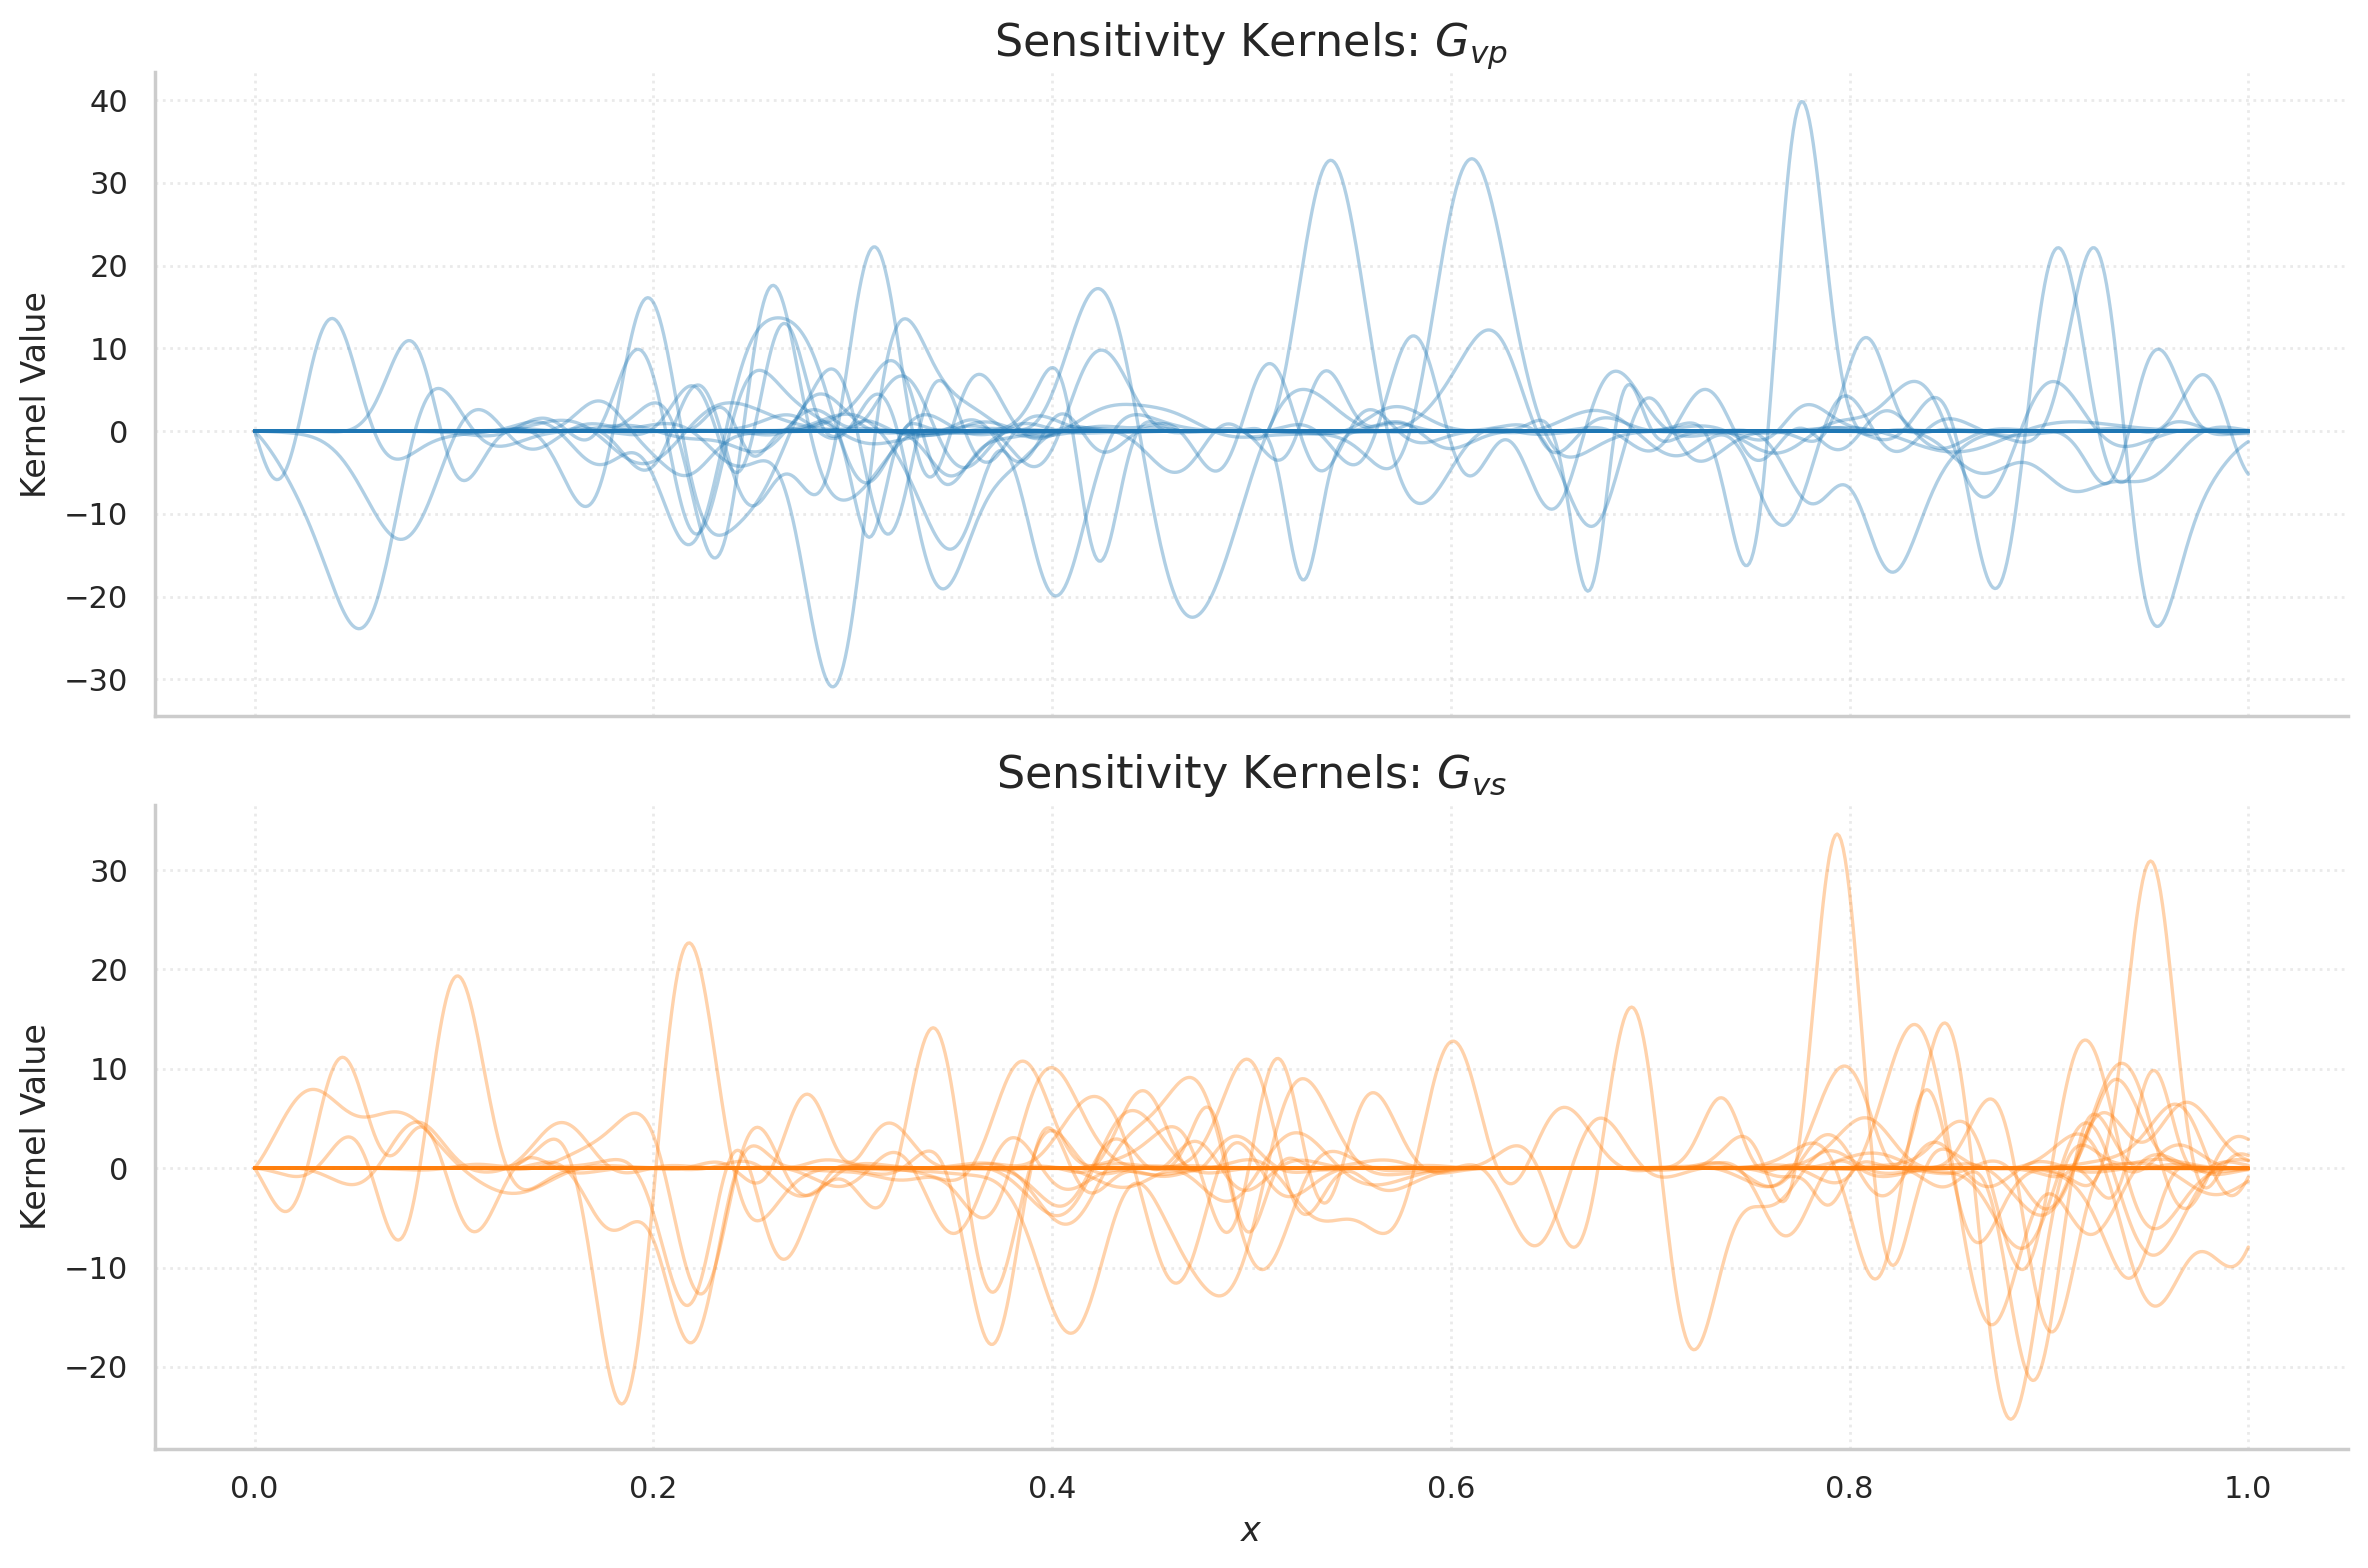

In [5]:
# Sensitivity Kernels figure
fig_title = "Sensitivity Kernels (vp & vs)"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

x = np.linspace(function_domain.a, function_domain.b, 1000)

sns.set_theme(style="whitegrid", palette="muted", color_codes=True)
plt.figure(figsize=(12, 8), dpi=200)

# Create two vertically stacked subplots: top for G_vp, bottom for G_vs
fig, axs = plt.subplots(2, 1, figsize=(12, 8), dpi=200, sharex=True)

# Top subplot: G_vp kernels
axs[0].set_title(r"Sensitivity Kernels: $G_{vp}$", fontsize=16)
for i in range(N_d):
    axs[0].plot(
        x,
        G_vp.get_kernel(i).evaluate(x),
        color='tab:blue',
        alpha=0.35,
        linewidth=1.2,
    )
axs[0].set_ylabel("Kernel Value", fontsize=12)
axs[0].grid(True, linestyle=':', alpha=0.4)

# Bottom subplot: G_vs kernels
axs[1].set_title(r"Sensitivity Kernels: $G_{vs}$", fontsize=16)
for i in range(N_d):
    axs[1].plot(
        x,
        G_vs.get_kernel(i).evaluate(x),
        color='tab:orange',
        alpha=0.35,
        linewidth=1.2,
    )
axs[1].set_xlabel(r"$x$", fontsize=12)
axs[1].set_ylabel("Kernel Value", fontsize=12)
axs[1].grid(True, linestyle=':', alpha=0.4)

sns.despine()
plt.tight_layout()

# Save as both PNG and PDF for publication
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()

### Sensitivity Kernels Visualization

The sensitivity kernels $K_i(x)$ define how sensitive each data point $d_i$ is to the model $m(x)$ at different spatial locations. These kernels are crucial for understanding:

- **Coverage**: Where in the domain we have observational sensitivity
- **Resolution**: How localized our measurements are
- **Redundancy**: Overlapping kernels indicate multiple measurements of similar information

Regions where many kernels overlap (appearing darker) represent areas of high observational density, while sparse regions indicate limited sensitivity.

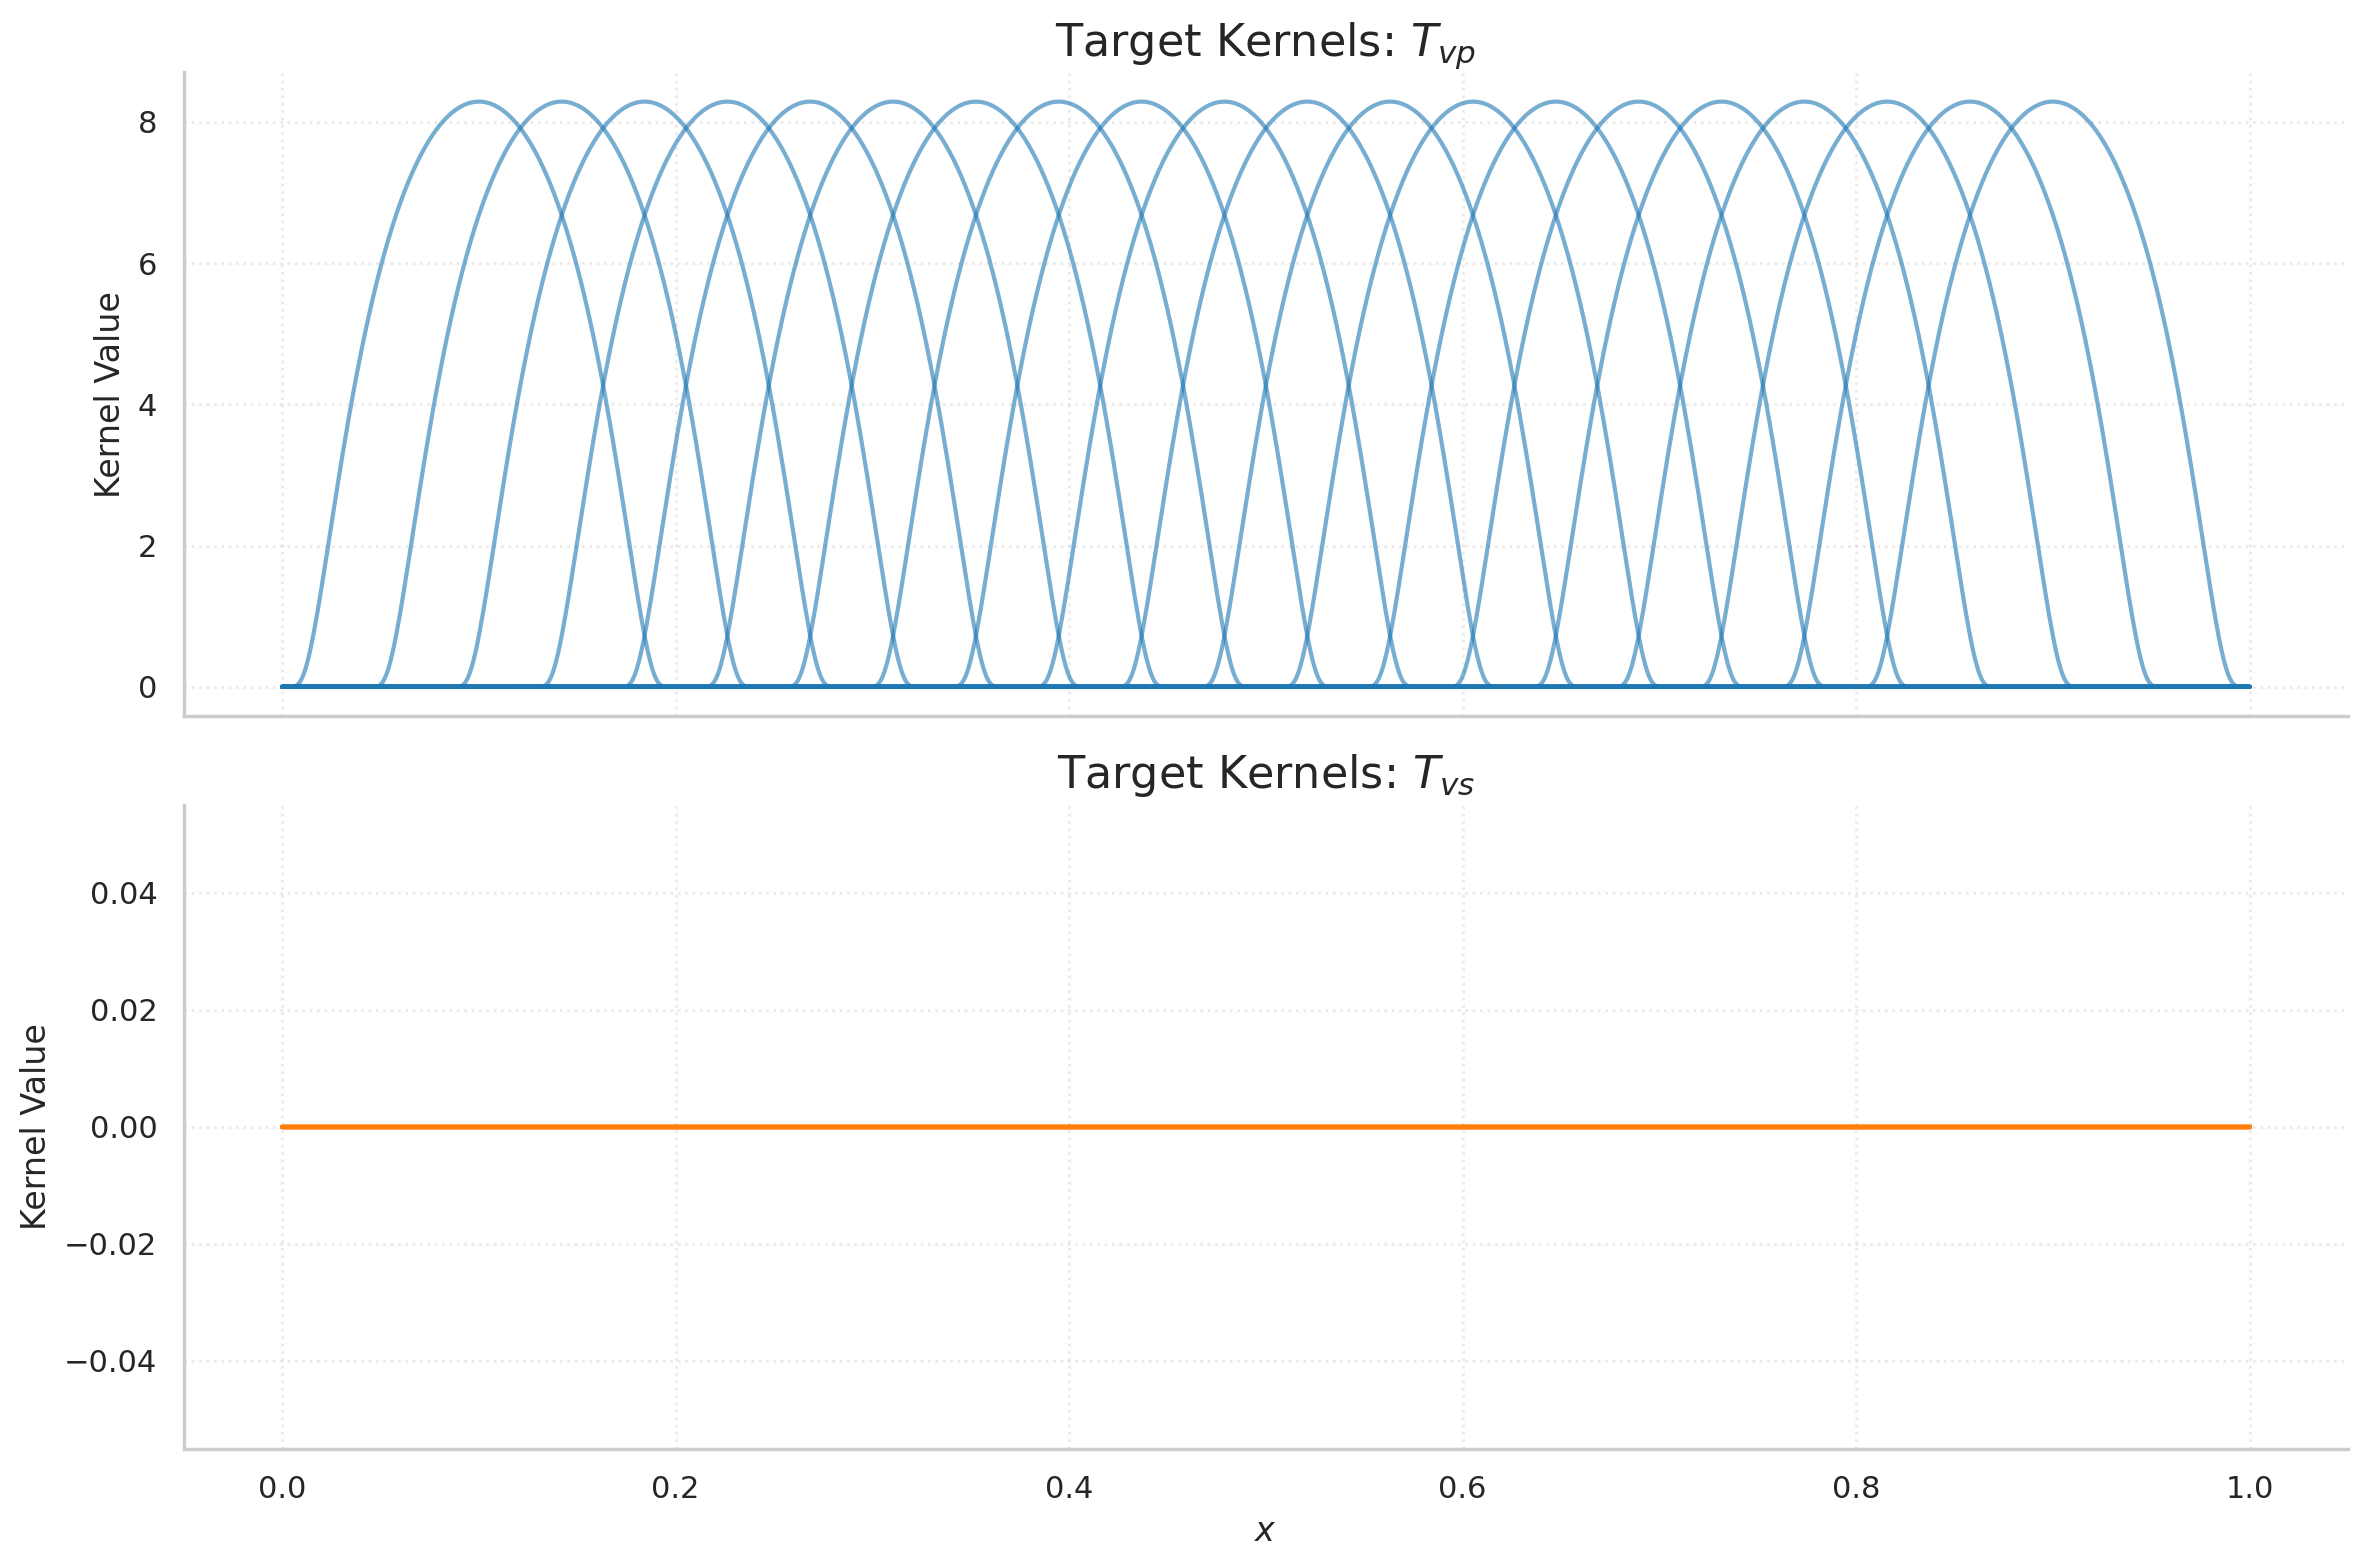

In [6]:
# Target Kernels figure (vp & vs)
fig_title = "Target Kernels (vp & vs)"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

x = np.linspace(function_domain.a, function_domain.b, 1000)

sns.set_theme(style="whitegrid", palette="muted", color_codes=True)

# Two vertically stacked subplots: top for T_vp, bottom for T_vs
fig, axs = plt.subplots(2, 1, figsize=(12, 8), dpi=200, sharex=True)

# Top: T_vp
axs[0].set_title(r"Target Kernels: $T_{vp}$", fontsize=16)
for i in range(N_p):
    axs[0].plot(
        x,
        T_vp.get_kernel(i).evaluate(x),
        color='tab:blue',
        alpha=0.6,
        linewidth=1.5,
    )
axs[0].set_ylabel("Kernel Value", fontsize=12)
axs[0].grid(True, linestyle=':', alpha=0.4)

# Bottom: T_vs
axs[1].set_title(r"Target Kernels: $T_{vs}$", fontsize=16)
for i in range(N_p):
    axs[1].plot(
        x,
        T_vs.get_kernel(i).evaluate(x),
        color='tab:orange',
        alpha=0.6,
        linewidth=1.5,
    )
axs[1].set_xlabel(r"$x$", fontsize=12)
axs[1].set_ylabel("Kernel Value", fontsize=12)
axs[1].grid(True, linestyle=':', alpha=0.4)

sns.despine()
plt.tight_layout()

# Save as both PNG and PDF
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()

### Target Kernels for Property Extraction

The target kernels $T_i(x)$ define the properties we want to infer about the model. Each kernel extracts a local average of the model around its center location. These bump functions allow us to:

- **Localize**: Extract spatially localized properties
- **Regularize**: Smooth local estimates through spatial averaging  
- **Focus**: Target specific regions of interest in the domain

## Synthetic Data Generation

### True Model Construction

We create a synthetic "true" model $\bar{m}(x)$ that combines multiple scales of variation:

$$\bar{m}(x) = \exp\left(-\frac{(x - 0.5)^2}{0.5^2}\right) \sin(5\pi x) + x$$

This model includes:
- **Global trend**: Linear component $x$ 
- **Localized oscillation**: Gaussian-windowed sine wave for fine-scale structure
- **Smooth envelope**: Exponential decay for spatial localization

From this true model, we generate synthetic observations $\mathbf{\bar{d}} = G(\bar{m})$ and add noise to create realistic measurements $\mathbf{\tilde{d}}$.

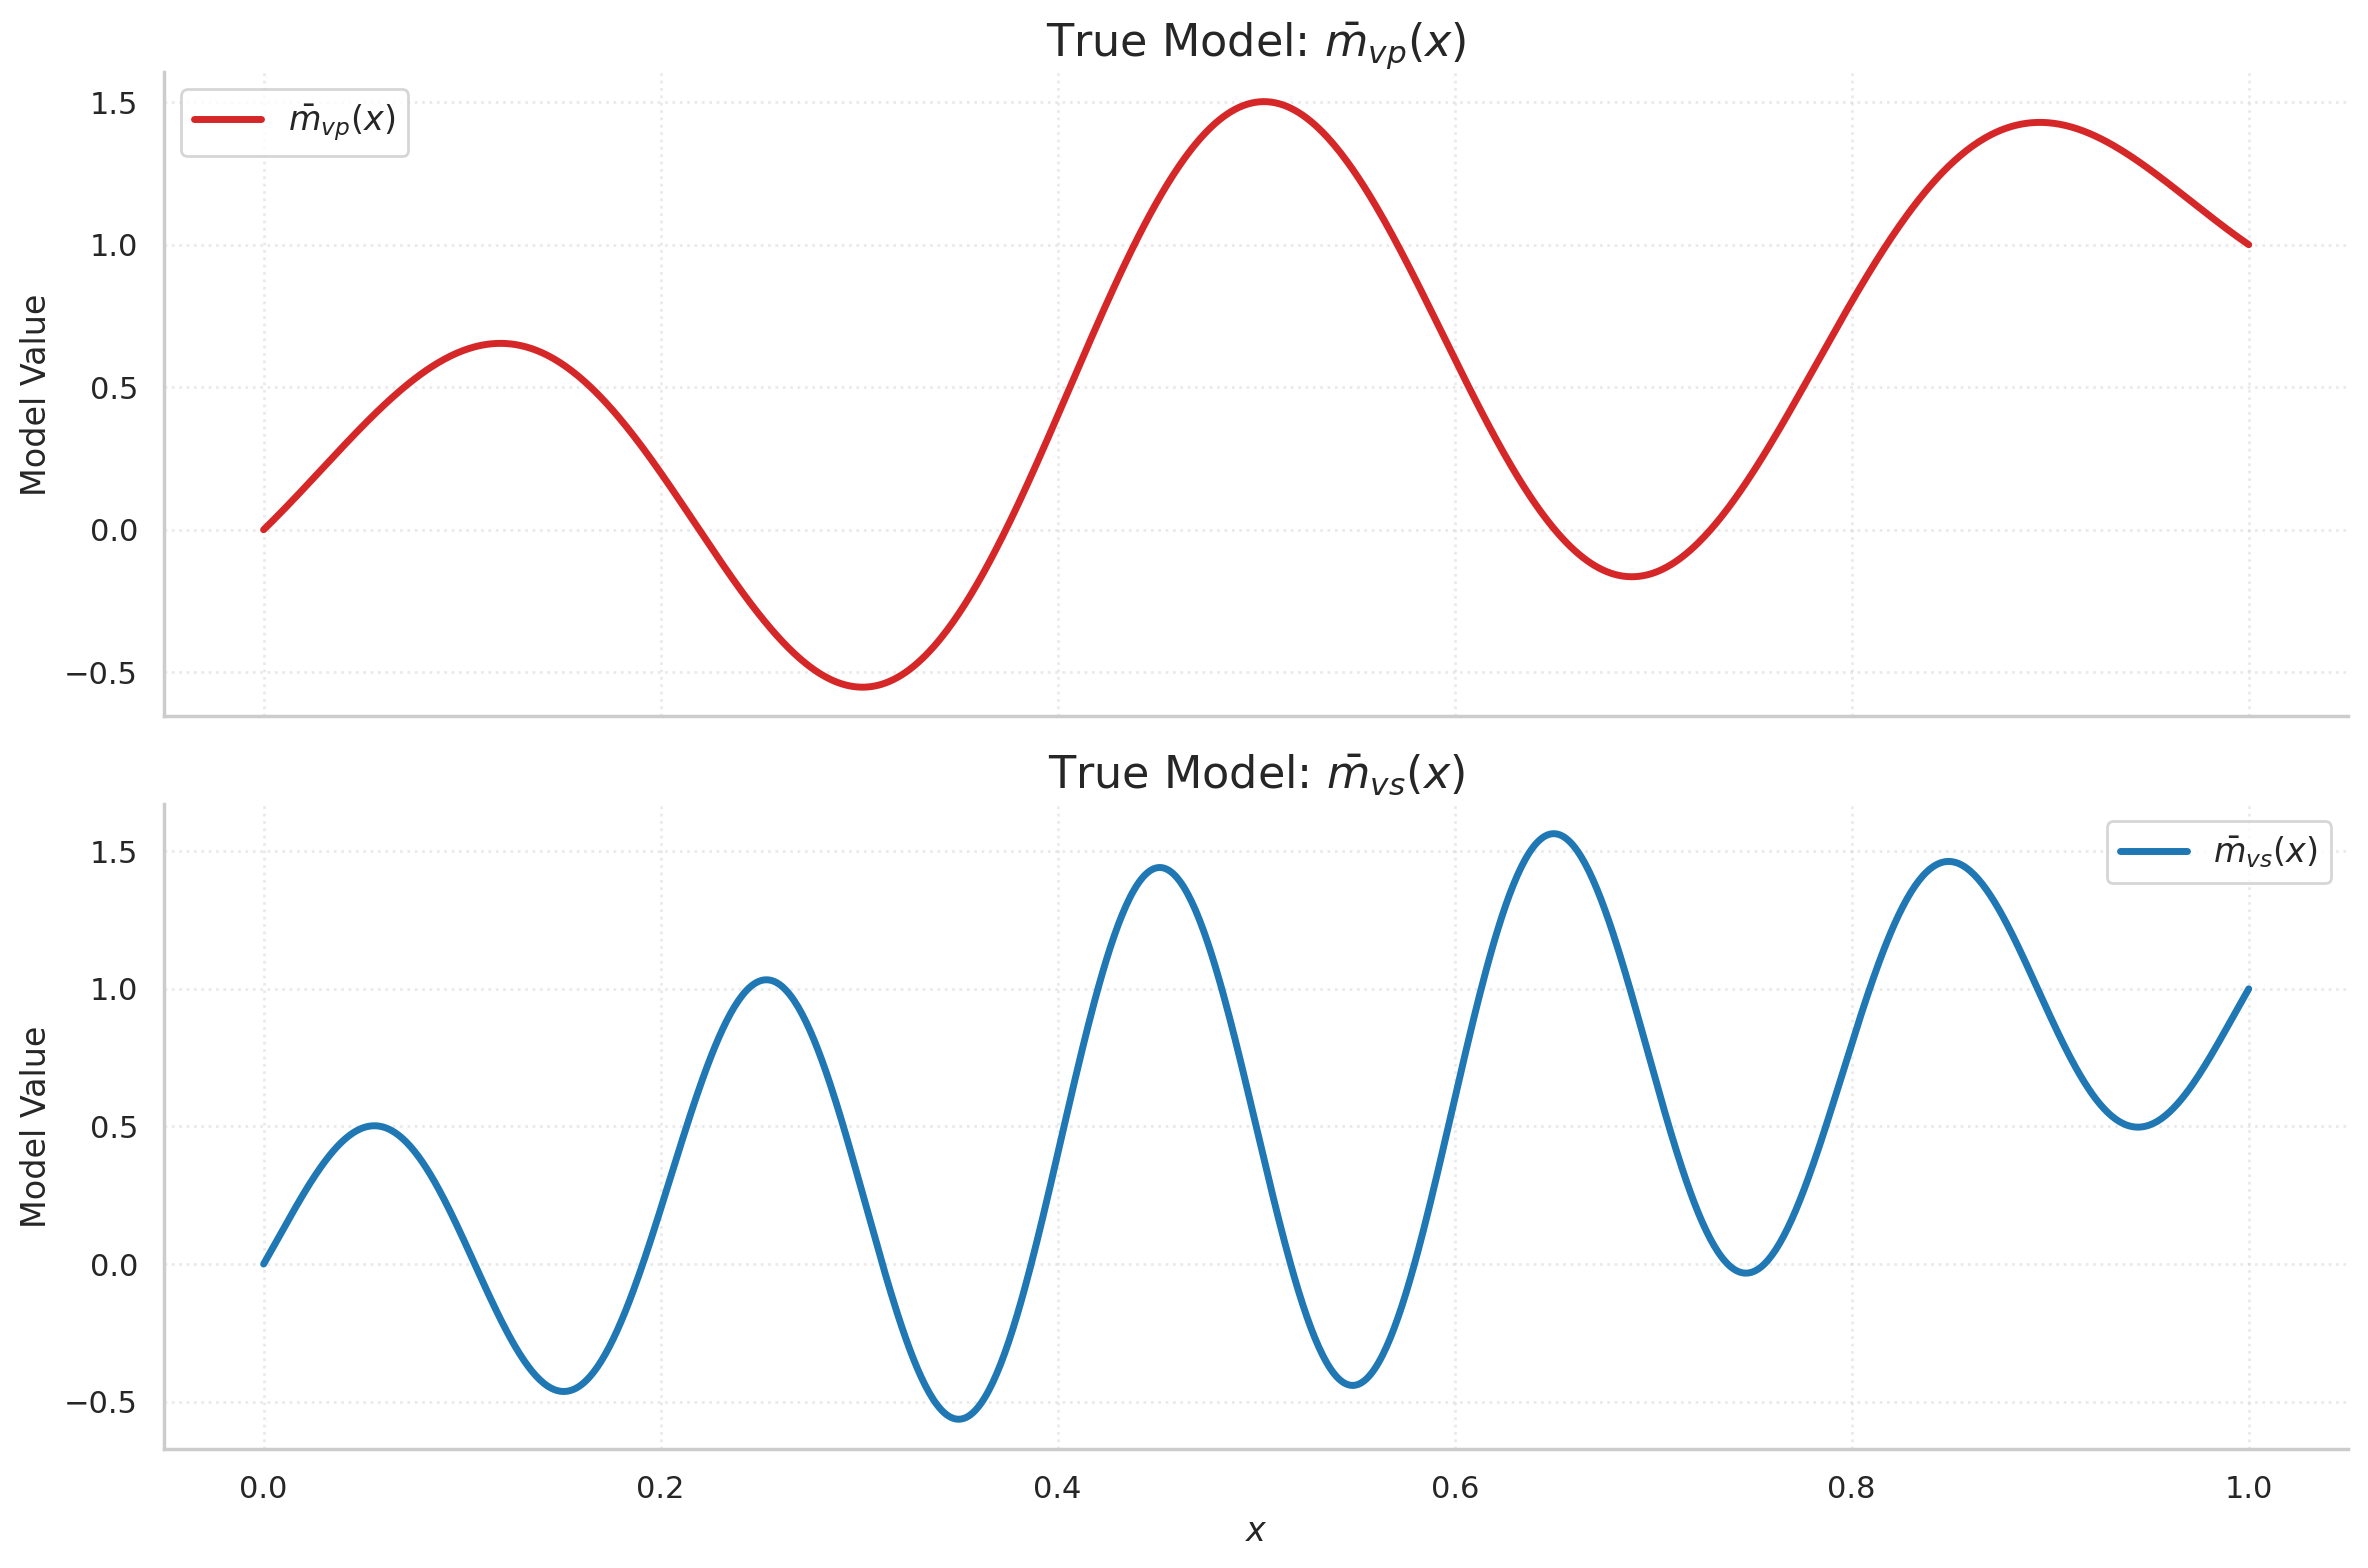

Generating synthetic data...
Signal-to-noise ratio: 10.0
Number of observations: 50


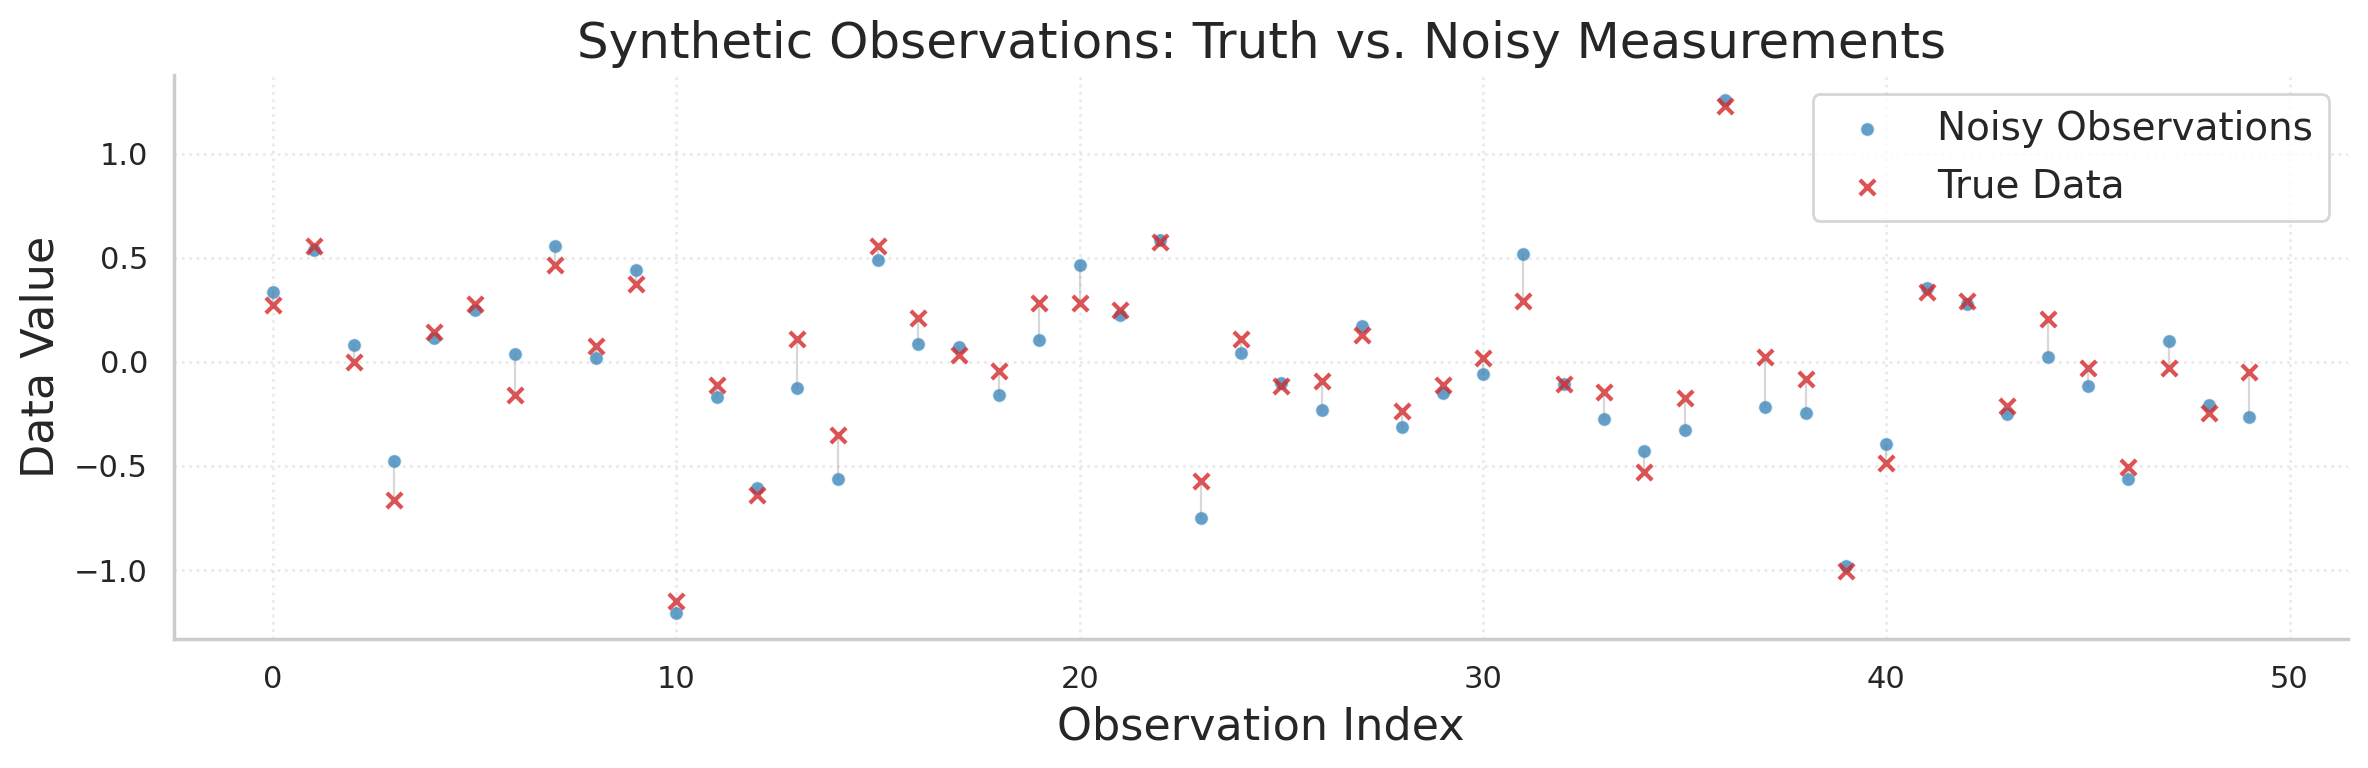

In [7]:
# Create the synthetic true models for vp and vs
m_bar_vp = Function(M_vp, evaluate_callable=lambda x: np.exp(-((x - function_domain.center)/0.5)**2) * np.sin(5 * np.pi * x) + x)
m_bar_vs = Function(M_vs, evaluate_callable=lambda x: np.exp(-((x - function_domain.center)/0.5)**2) * np.sin(10 * np.pi * x) + x)
# Keep a combined representation if needed elsewhere
m_bar = [m_bar_vp, m_bar_vs]

# Evaluation grid (ensure x is defined locally)
x = np.linspace(function_domain.a, function_domain.b, 1000)

# True model plots: two stacked subplots (vp on top, vs on bottom)
fig_title = "True Models (vp & vs)"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

sns.set_theme(style="whitegrid", palette="muted", color_codes=True)
fig, axs = plt.subplots(2, 1, figsize=(12, 8), dpi=200, sharex=True)

# Top: vp
axs[0].plot(x, m_bar_vp.evaluate(x), color='tab:red', linewidth=2.5, label=r'$\bar{m}_{vp}(x)$')
axs[0].set_title(r"True Model: $\bar{m}_{vp}(x)$", fontsize=16)
axs[0].set_ylabel('Model Value', fontsize=12)
axs[0].legend(fontsize=12)
axs[0].grid(True, linestyle=':', alpha=0.4)

# Bottom: vs
axs[1].plot(x, m_bar_vs.evaluate(x), color='tab:blue', linewidth=2.5, label=r'$\bar{m}_{vs}(x)$')
axs[1].set_title(r"True Model: $\bar{m}_{vs}(x)$", fontsize=16)
axs[1].set_xlabel(r"$x$", fontsize=12)
axs[1].set_ylabel('Model Value', fontsize=12)
axs[1].legend(fontsize=12)
axs[1].grid(True, linestyle=':', alpha=0.4)

sns.despine()
plt.tight_layout()

# Save
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()

# Generate synthetic observations
print("Generating synthetic data...")
d_bar = G(m_bar)  # Clean observations (may be a list/BlockVector)
# Ensure d_bar is a numpy array for noise addition and plotting

# Compute noise based on the numeric array
noise_level = 0.1 * np.max(d_bar)
np.random.seed(42)  # For reproducibility
d_tilde = [sub_d_bar + np.random.normal(0, noise_level, sub_d_bar.shape) for sub_d_bar in d_bar]

print(f"Signal-to-noise ratio: {np.max(d_bar) / noise_level:.1f}")
print(f"Number of observations: {len(d_tilde)}")

# Data comparison plot
fig_title = "Synthetic Observations"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

plt.figure(figsize=(12, 4), dpi=200)
data_indices = np.arange(len(d_bar))

# Plot connection lines between true and noisy data
for i in range(len(d_bar)):
    plt.plot([i, i], [d_bar[i], d_tilde[i]], color='gray', alpha=0.3, linewidth=0.8)

# Plot the data points
plt.scatter(data_indices, d_tilde, label='Noisy Observations',
           color='tab:blue', alpha=0.7, marker='o', s=25, edgecolors='white', linewidths=0.5)
plt.scatter(data_indices, d_bar, label='True Data',
           color='tab:red', alpha=0.8, marker='x', s=30, linewidths=1.5)

plt.xlabel('Observation Index', fontsize=16)
plt.ylabel('Data Value', fontsize=16)
plt.title('Synthetic Observations: Truth vs. Noisy Measurements', fontsize=18)
plt.legend(fontsize=14)
plt.grid(True, linestyle=':', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()

## Bayesian Setup: Data and Prior Measures

### Data Noise Model

We model the measurement noise as independent Gaussian with known variance:
$$\mathbf{\eta} \sim \mathcal{N}(\mathbf{0}, \mathbf{C}_{\mathcal{D}})$$

where $\mathbf{C}_{\mathcal{D}} = \sigma^2 \mathbf{I}$ represents uncorrelated measurement errors. This gives us the data likelihood:
$$\mathbf{\tilde{d}} | m \sim \mathcal{N}(G(m), \mathbf{C}_{\mathcal{D}})$$

**Important distinction**: 
- **Data error measure**: $\mathcal{N}(\mathbf{0}, \mathbf{C}_{\mathcal{D}})$ - represents the noise model for `LinearForwardProblem`
- **Data measure**: $\mathcal{N}(\mathbf{\tilde{d}}, \mathbf{C}_{\mathcal{D}})$ - represents the observed data for visualization

In [8]:
# Define data noise covariance
noise_variance = (0.1 * np.max(d_tilde))**2  # 10% of peak signal
C_D_matrix = noise_variance * np.eye(N_d)

print(f"Data noise standard deviation: {np.sqrt(noise_variance):.4f}")
print(f"Relative noise level: {100 * np.sqrt(noise_variance) / np.max(d_tilde):.1f}%")

# Create data NOISE measure (zero mean) for LinearForwardProblem
# This represents the noise model: η ~ N(0, C_D)
gaussian_D_noise = GaussianMeasure.from_covariance_matrix(D, C_D_matrix, expectation=np.zeros(N_d))

# Create data measure (with observed data mean) for visualization
# This represents the likelihood: d̃ | m ~ N(G(m), C_D)
gaussian_D = GaussianMeasure.from_covariance_matrix(D, C_D_matrix, expectation=d_tilde)

Data noise standard deviation: 0.1257
Relative noise level: 10.0%


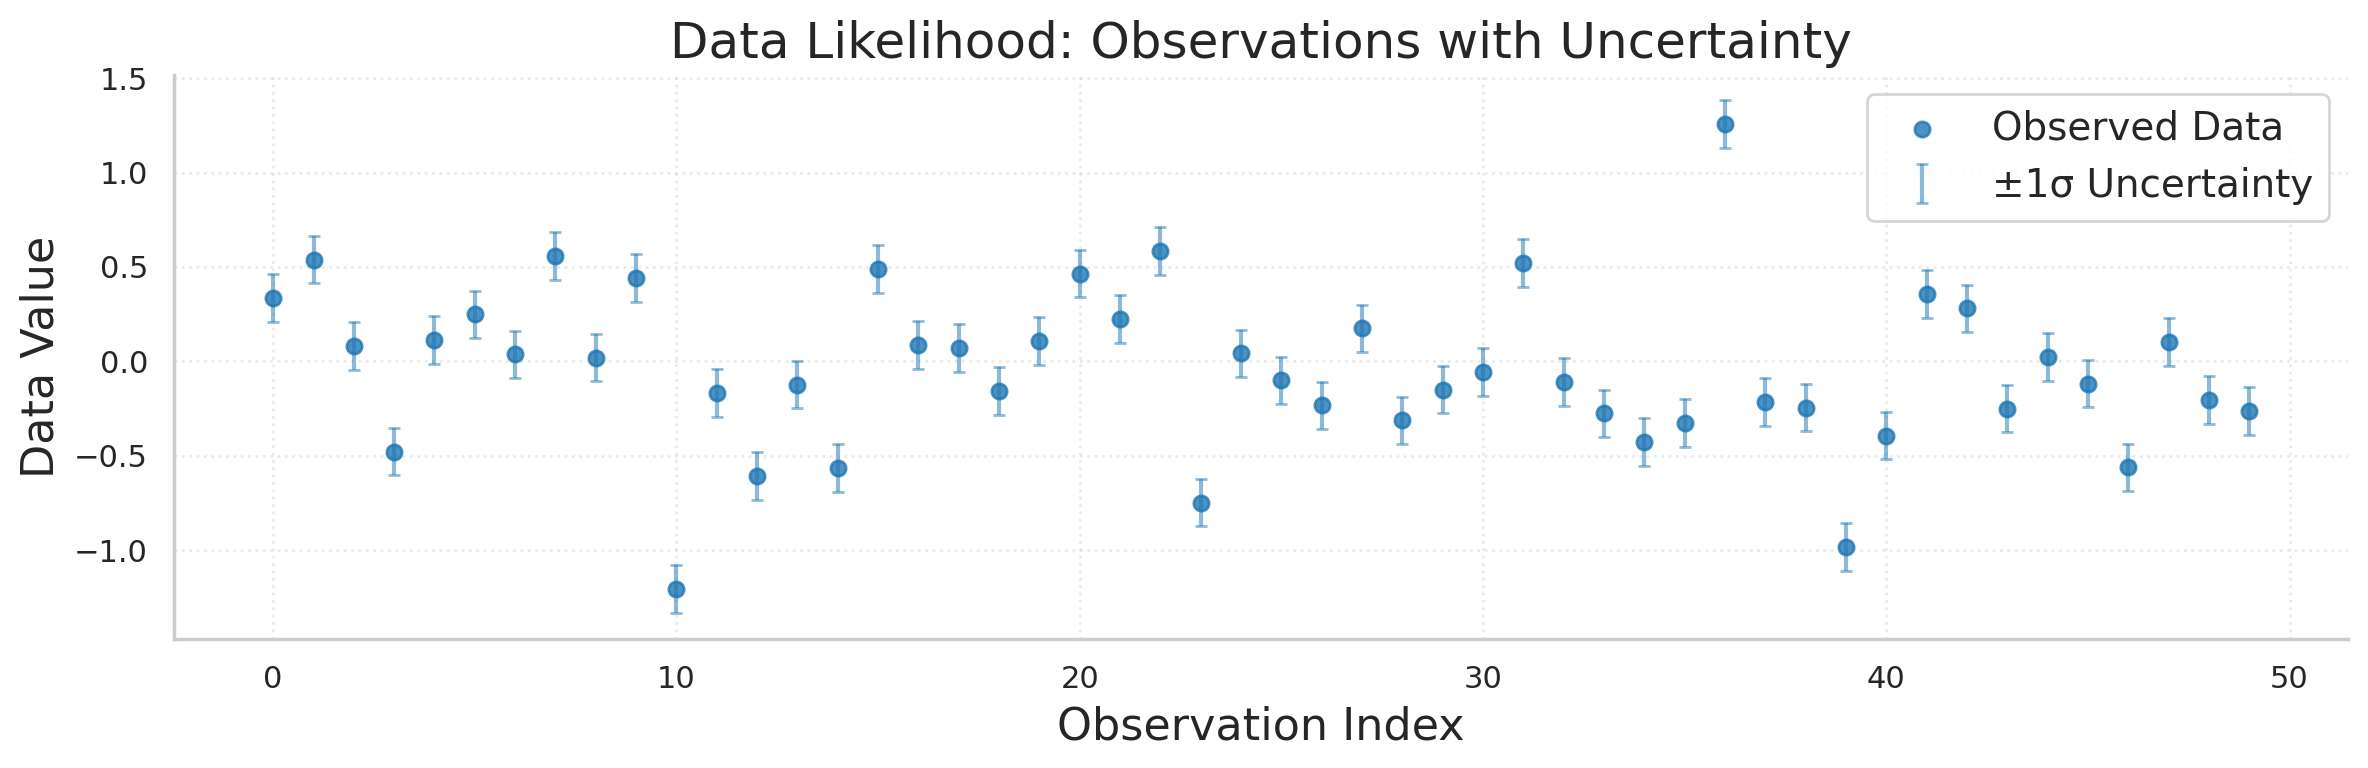

In [9]:
# Visualize the data measure (observed data with uncertainty)
# Note: We use gaussian_D (with data mean) for visualization, not gaussian_D_error (zero mean)
mean_values = gaussian_D.expectation
std_values = np.sqrt(noise_variance)

fig_title = "Data Likelihood Distribution"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

plt.figure(figsize=(12, 4), dpi=200)
data_indices = np.arange(len(mean_values))

plt.scatter(data_indices, mean_values, label='Observed Data', color='tab:blue', alpha=0.8, s=30)
plt.errorbar(data_indices, mean_values, yerr=std_values, fmt='none',
            color='tab:blue', alpha=0.5, capsize=2, capthick=1,
            label='±1σ Uncertainty')

plt.title("Data Likelihood: Observations with Uncertainty", fontsize=18)
plt.xlabel('Observation Index', fontsize=16)
plt.ylabel('Data Value', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True, linestyle=':', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()

### Prior Model

We assign a Gaussian prior measure to regularize the inverse problem:
$$m \sim \mu_{\mathcal{M}}^0 = \mathcal{N}(m_0, C_0)$$

**Prior Mean**: $m_0^{vp}(x) = x$, $m_0^{vs}(x) = \sin(x)$

**Prior Covariance**: We use the **Bessel-Sobolev inverse operator**:
$$C_0 = (k^2 I + L)^{-s}$$

where:
- $L = -\alpha \nabla^2$ is the negative Laplacian operator
- $k$ is the Bessel parameter controlling correlation length scale
- $s$ is the Sobolev order controlling smoothness/regularity

This choice provides:
- **Flexible regularization**: Control smoothness (s) and correlation length (k) independently
- **Well-conditioned operators**: Even for high smoothness orders
- **Fast computation**: Leverages fast DCT/DST spectral transforms
- **Explicit eigenfunction expansion**: For efficient KL sampling

The Bessel-Sobolev operator generalizes the inverse Laplacian (which corresponds to $k^2 \to 0$, $s = 1$).

In [10]:
# Define prior measure parameters
bc_dirichlet = BoundaryConditions(bc_type='dirichlet', left=0, right=0)

# Bessel-Sobolev parameters
k_vp = 1.0      # Bessel parameter (correlation length scale)
s_vp = 8.0      # Sobolev order (smoothness)
alpha_vp = 0.1  # Laplacian scaling

k_vs = 1.0
s_vs = 6.0
alpha_vs = 0.05

# Create Laplacian operators
L_vp = Laplacian(M_vp, bc_dirichlet, alpha_vp, method='spectral', dofs=100, n_samples=2048)
L_vs = Laplacian(M_vs, bc_dirichlet, alpha_vs, method='spectral', dofs=100, n_samples=2048)

# Create Bessel-Sobolev inverse operators as prior covariance
C_0_vp = BesselSobolevInverse(
    M_vp, M_vp, k_vp, s_vp, L_vp,
    dofs=100, n_samples=2048, use_fast_transforms=True
)
C_0_vs = BesselSobolevInverse(
    M_vs, M_vs, k_vs, s_vs, L_vs,
    dofs=100, n_samples=2048, use_fast_transforms=True
)

# Prior means
m_0_vp = Function(M_vp, evaluate_callable=lambda x: x)
m_0_vs = Function(M_vs, evaluate_callable=lambda x: np.sin(x))

print(f"Prior covariance (vp): (k²I + L)^(-s) with k={k_vp}, s={s_vp}, α={alpha_vp}")
print(f"Prior covariance (vs): (k²I + L)^(-s) with k={k_vs}, s={s_vs}, α={alpha_vs}")
print(f"  Using fast spectral transforms (DCT/DST)")
print(f"Prior mean (vp): m₀(x) = x")
print(f"Prior mean (vs): m₀(x) = sin(x)")

# Set up Karhunen-Loève expansion for efficient sampling
K = 100  # Number of KL terms (should be ≥ N for full representation)
print(f"\nUsing {K} Karhunen-Loève terms for prior sampling")

# Create Gaussian measure on model space
M_prior_vp = GaussianMeasure.from_spectral(C_0_vp, expectation=m_0_vp, n_modes=K)
M_prior_vs = GaussianMeasure.from_spectral(C_0_vs, expectation=m_0_vs, n_modes=K)

# Combine into a joint prior measure
M_prior = GaussianMeasure.from_direct_sum([M_prior_vp, M_prior_vs])

# Display eigenvalue decay
eigenvals_vp = C_0_vp.get_eigenvalues(range(50))
eigenvals_vs = C_0_vs.get_eigenvalues(range(50))
print(f"\nEigenvalue range (vp): [{eigenvals_vp[-1]:.2e}, {eigenvals_vp[0]:.2e}]")
print(f"Spectral decay rate (vp): {eigenvals_vp[0]/eigenvals_vp[-1]:.1e}")
print(f"Eigenvalue range (vs): [{eigenvals_vs[-1]:.2e}, {eigenvals_vs[0]:.2e}]")
print(f"Spectral decay rate (vs): {eigenvals_vs[0]/eigenvals_vs[-1]:.1e}")

# Show Bessel-Sobolev scaling for first few modes
print(f"\nBessel-Sobolev eigenvalue scaling (vp):")
print(f"  First 5 eigenvalues of L: {[L_vp.get_eigenvalue(i) for i in range(5)]}")
print(f"  Corresponding C_0 eigenvalues: {eigenvals_vp[:5]}")
print(f"  Formula: (k² + λᵢ)^(-s) = ({k_vp}² + λᵢ)^(-{s_vp})")

Prior covariance (vp): (k²I + L)^(-s) with k=1.0, s=8.0, α=0.1
Prior covariance (vs): (k²I + L)^(-s) with k=1.0, s=6.0, α=0.05
  Using fast spectral transforms (DCT/DST)
Prior mean (vp): m₀(x) = x
Prior mean (vs): m₀(x) = sin(x)

Using 100 Karhunen-Loève terms for prior sampling

Eigenvalue range (vp): [2.65e-10, 6.86e-01]
Spectral decay rate (vp): 2.6e+09
Eigenvalue range (vs): [4.06e-06, 9.29e-01]
Spectral decay rate (vs): 2.3e+05

Bessel-Sobolev eigenvalue scaling (vp):
  First 5 eigenvalues of L: [0.09869604401089359, 0.39478417604357435, 0.8882643960980423, 1.5791367041742974, 2.46740110027234]
  Corresponding C_0 eigenvalues: [0.6862616922360015, 0.2642238117629081, 0.07865906545234395, 0.022599693638491, 0.006918049567040543]
  Formula: (k² + λᵢ)^(-s) = (1.0² + λᵢ)^(-8.0)


### Bessel-Sobolev Parameter Selection

The Bessel-Sobolev prior covariance $C_0 = (k^2 I + L)^{-s}$ provides flexible control over the prior:

**Parameter $k$ (Bessel parameter)**:
- Controls the **correlation length scale**: $\ell \sim k^{-1}$
- Smaller $k$ → longer correlations, smoother spatial variations
- Larger $k$ → shorter correlations, more localized features
- Typical range: $k \in [0.5, 5.0]$

**Parameter $s$ (Sobolev order)**:
- Controls the **smoothness/regularity** of prior samples
- Higher $s$ → smoother samples, stronger regularization
- Lower $s$ → more flexible, less smooth
- Typical values: $s \in [0.5, 2.0]$, with $s = 1.0$ being common

**Current Configuration:**
- $v_p$ component: $k_{vp} = 1.0$, $s_{vp} = 1.0$, $\alpha_{vp} = 0.1$
- $v_s$ component: $k_{vs} = 1.0$, $s_{vs} = 1.0$, $\alpha_{vs} = 0.05$

These parameters can be tuned based on:
1. Expected spatial correlation scales in the true model
2. Desired smoothness of reconstructions
3. Data density and noise levels
4. Results from parameter sweeps (see `example_sweep.py` option 6)

### Prior Measure Visualization

The Gaussian prior encodes our beliefs about the model before seeing data. We can visualize this through:
- **Samples**: Random realizations from the prior
- **Mean**: Expected model structure  
- **Uncertainty**: Point-wise standard deviation showing prior variability

Drawing samples from prior measure...
Computing prior uncertainty (vp)...
Computing prior uncertainty (vs)...


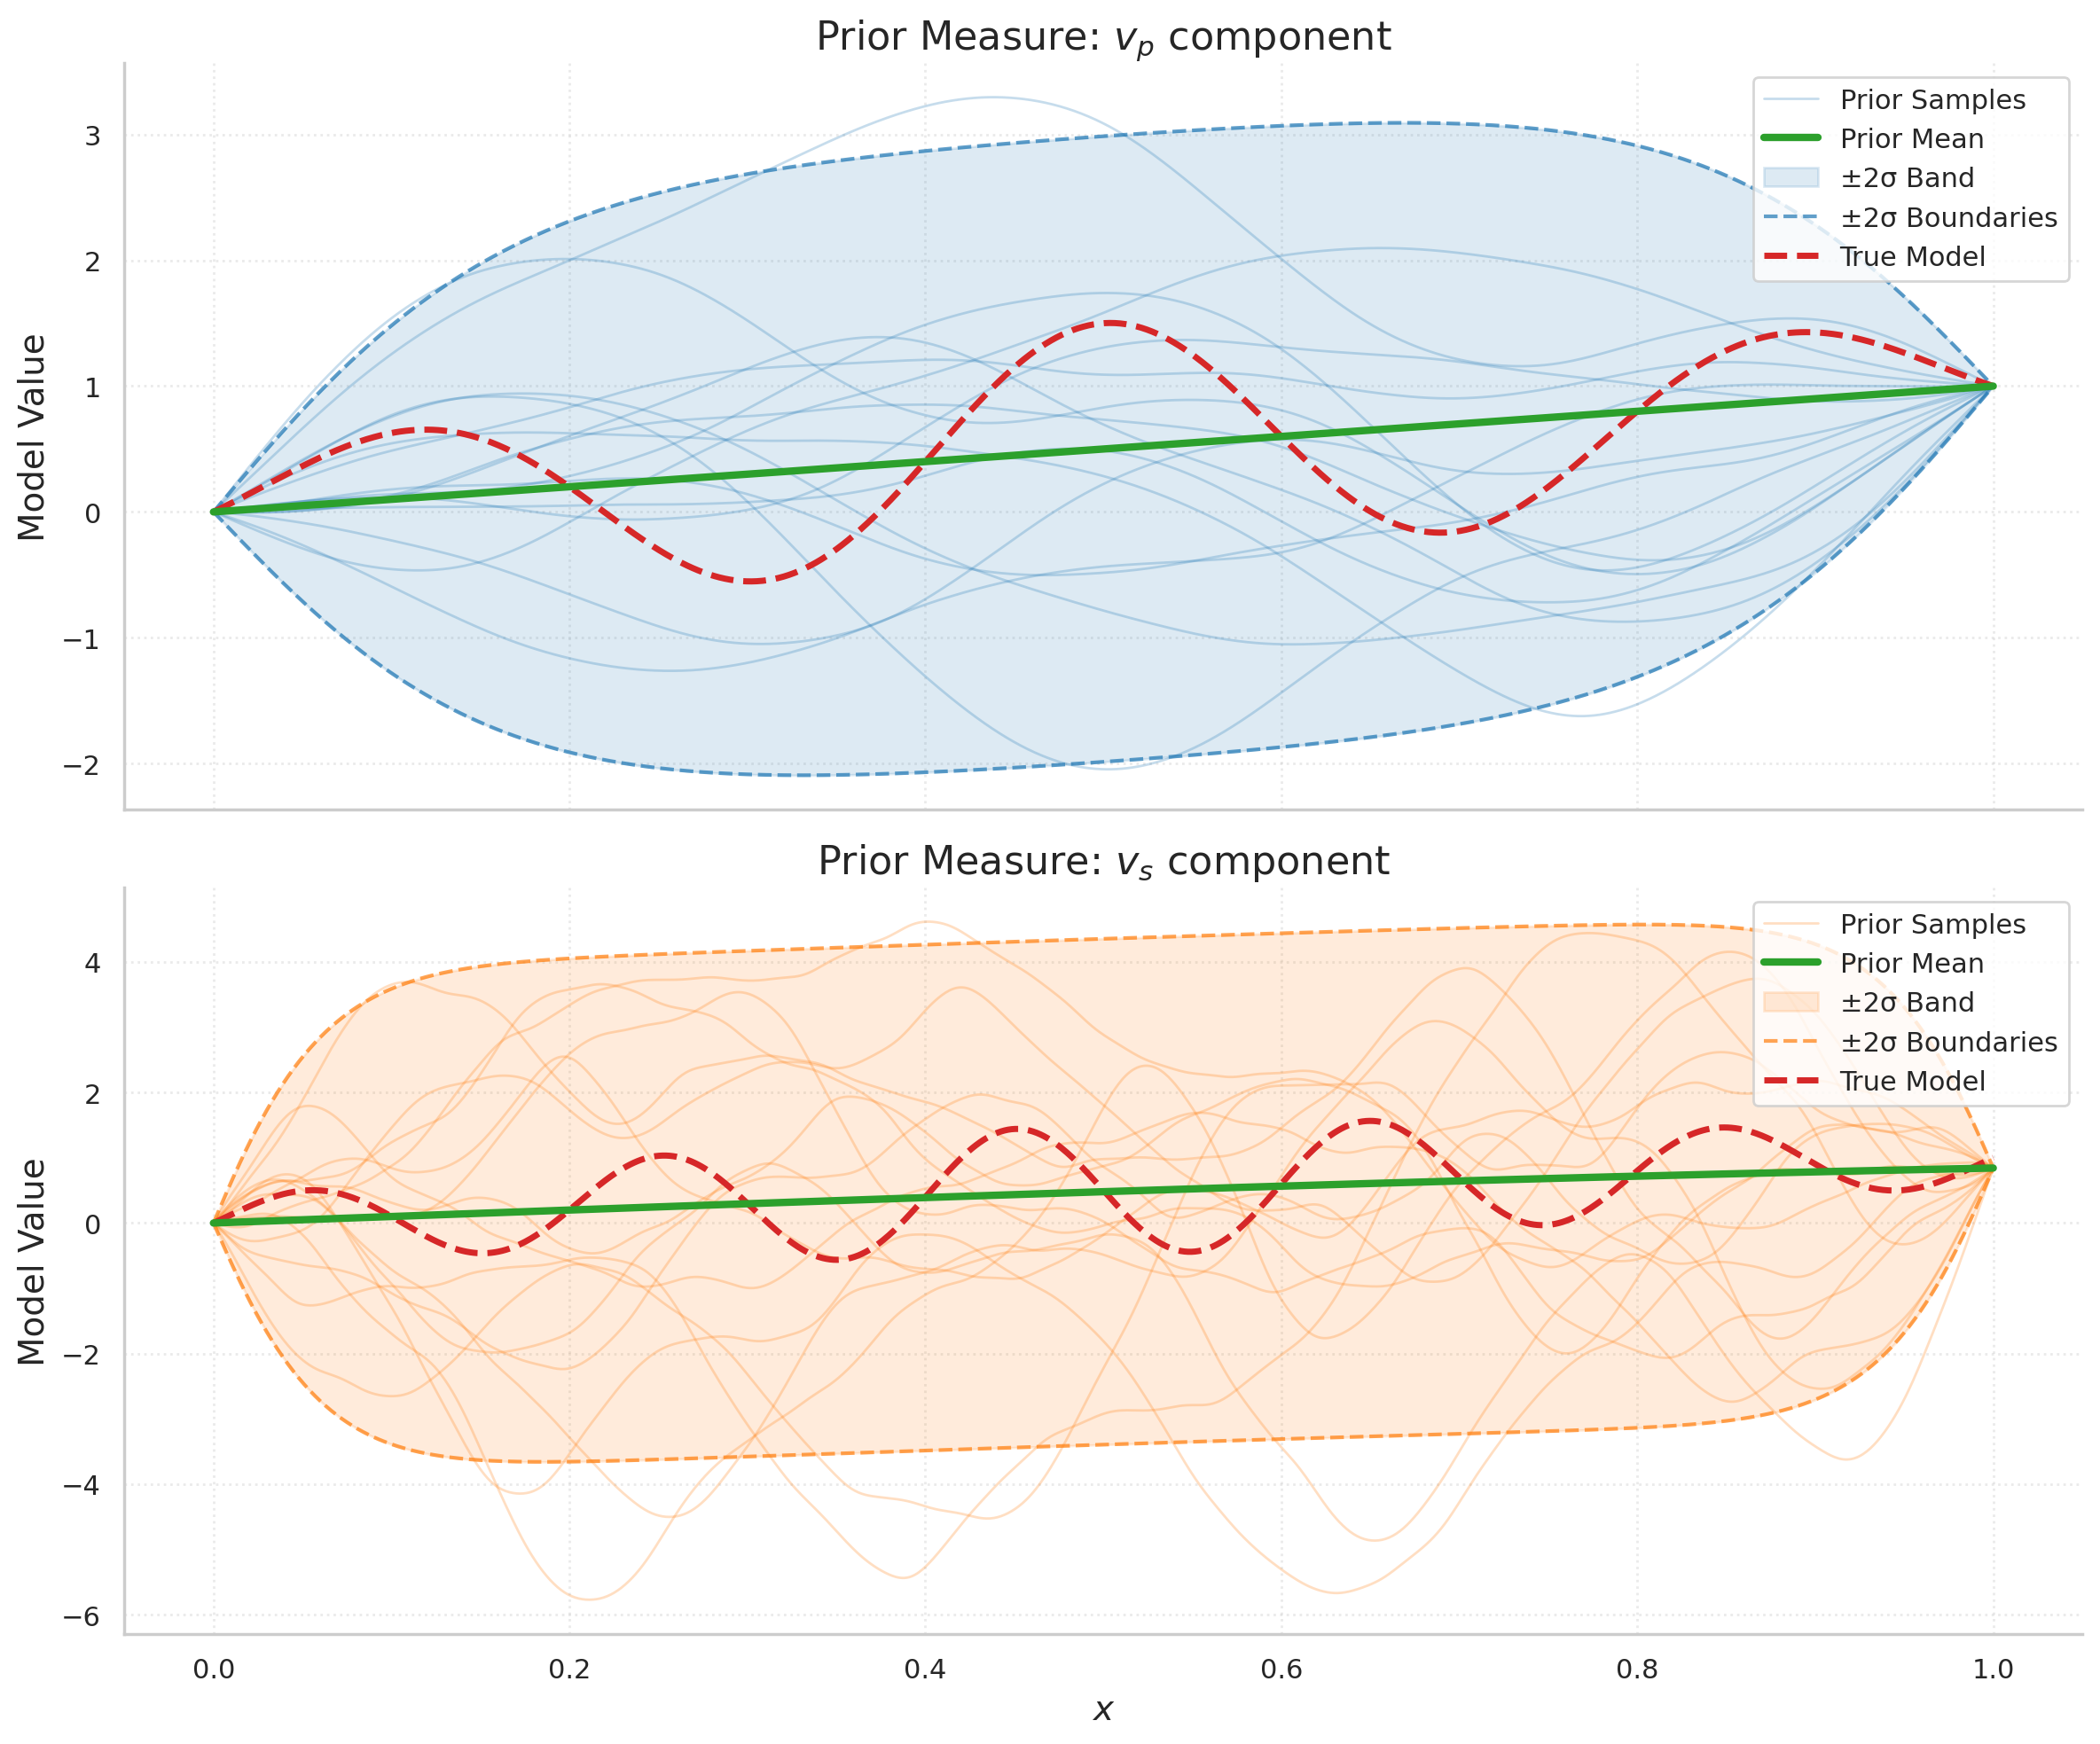

In [11]:
# Visualize the prior measure (two subplots for vp and vs)
fig_title = "Prior Measure on Model Space (vp & vs)"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

# Parameters for visualization
num_samples = 15
sample_color_vp = 'tab:blue'
sample_color_vs = 'tab:orange'
mean_color = 'tab:green'
std_color_vp = 'tab:blue'
std_color_vs = 'tab:orange'

# Create two vertically stacked subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 10), dpi=200, sharex=True)

# Plot prior samples for vp and vs
print("Drawing samples from prior measure...")
for i in range(num_samples):
    sample = M_prior.sample()  # Returns [sample_vp, sample_vs]
    sample_vp, sample_vs = sample

    # Top subplot: vp
    axs[0].plot(x, sample_vp.evaluate(x), color=sample_color_vp, alpha=0.25, linewidth=1,
                label='Prior Samples' if i == 0 else "")

    # Bottom subplot: vs
    axs[1].plot(x, sample_vs.evaluate(x), color=sample_color_vs, alpha=0.25, linewidth=1,
                label='Prior Samples' if i == 0 else "")

# Compute and plot uncertainty bounds for vp
print("Computing prior uncertainty (vp)...")
std_vp = M_vp.zero
for i, eigenvalue in enumerate(C_0_vp.get_eigenvalues(range(100))):
    eigenfunction = C_0_vp.get_eigenfunction(i)
    std_vp += eigenvalue * eigenfunction * eigenfunction
std_values_vp = np.sqrt(std_vp.evaluate(x))

# Compute and plot uncertainty bounds for vs
print("Computing prior uncertainty (vs)...")
std_vs = M_vs.zero
for i, eigenvalue in enumerate(C_0_vs.get_eigenvalues(range(100))):
    eigenfunction = C_0_vs.get_eigenfunction(i)
    std_vs += eigenvalue * eigenfunction * eigenfunction
std_values_vs = np.sqrt(std_vs.evaluate(x))

# Plot prior mean and uncertainty for vp (top subplot)
mean_vp, mean_vs = M_prior.expectation  # Unpack direct-sum expectation
mean_values_vp = mean_vp.evaluate(x)
axs[0].plot(x, mean_values_vp, color=mean_color, linewidth=3, label='Prior Mean', zorder=10)
axs[0].fill_between(x, mean_values_vp - 2*std_values_vp, mean_values_vp + 2*std_values_vp,
                     color=std_color_vp, alpha=0.15, label='±2σ Band')
axs[0].plot(x, mean_values_vp + 2*std_values_vp, color=std_color_vp, linestyle='--',
            alpha=0.7, linewidth=1.5, label='±2σ Boundaries')
axs[0].plot(x, mean_values_vp - 2*std_values_vp, color=std_color_vp, linestyle='--',
            alpha=0.7, linewidth=1.5)

# Plot true vp model
axs[0].plot(x, m_bar_vp.evaluate(x), color='tab:red', linewidth=2.5,
            label='True Model', linestyle='--', zorder=9)

axs[0].set_title(r"Prior Measure: $v_p$ component", fontsize=16)
axs[0].set_ylabel("Model Value", fontsize=14)
axs[0].legend(fontsize=11, loc='upper right')
axs[0].grid(True, linestyle=':', alpha=0.4)

# Plot prior mean and uncertainty for vs (bottom subplot)
mean_values_vs = mean_vs.evaluate(x)
axs[1].plot(x, mean_values_vs, color=mean_color, linewidth=3, label='Prior Mean', zorder=10)
axs[1].fill_between(x, mean_values_vs - 2*std_values_vs, mean_values_vs + 2*std_values_vs,
                     color=std_color_vs, alpha=0.15, label='±2σ Band')
axs[1].plot(x, mean_values_vs + 2*std_values_vs, color=std_color_vs, linestyle='--',
            alpha=0.7, linewidth=1.5, label='±2σ Boundaries')
axs[1].plot(x, mean_values_vs - 2*std_values_vs, color=std_color_vs, linestyle='--',
            alpha=0.7, linewidth=1.5)

# Plot true vs model
axs[1].plot(x, m_bar_vs.evaluate(x), color='tab:red', linewidth=2.5,
            label='True Model', linestyle='--', zorder=9)

axs[1].set_title(r"Prior Measure: $v_s$ component", fontsize=16)
axs[1].set_xlabel(r"$x$", fontsize=14)
axs[1].set_ylabel("Model Value", fontsize=14)
axs[1].legend(fontsize=11, loc='upper right')
axs[1].grid(True, linestyle=':', alpha=0.4)

sns.despine()
plt.tight_layout()
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()

## Property Prior Analysis

### Push-forward of Model Prior

The property prior is obtained by pushing the model prior through the target operator:
$$\mu_{\mathcal{P}}^0 = \mathcal{T}_* \mu_{\mathcal{M}}^0 = \mathcal{N}(\mathcal{T}(m_0), \mathcal{T} C_0 \mathcal{T}^*)$$

This gives us prior beliefs about the local properties before incorporating data.

In [12]:
# Compute property prior by pushing model prior through target operator
print("Computing property prior measure...")
prior_P = M_prior.affine_mapping(operator=T)
std_P = np.sqrt(np.diag(prior_P.covariance.matrix(dense=True, parallel=True, n_jobs=30)))

print(f"Property prior computed for {N_p} target locations")
print(f"Property uncertainty range: [{std_P.min():.3f}, {std_P.max():.3f}]")

Computing property prior measure...
Property prior computed for 20 target locations
Property uncertainty range: [0.659, 1.224]


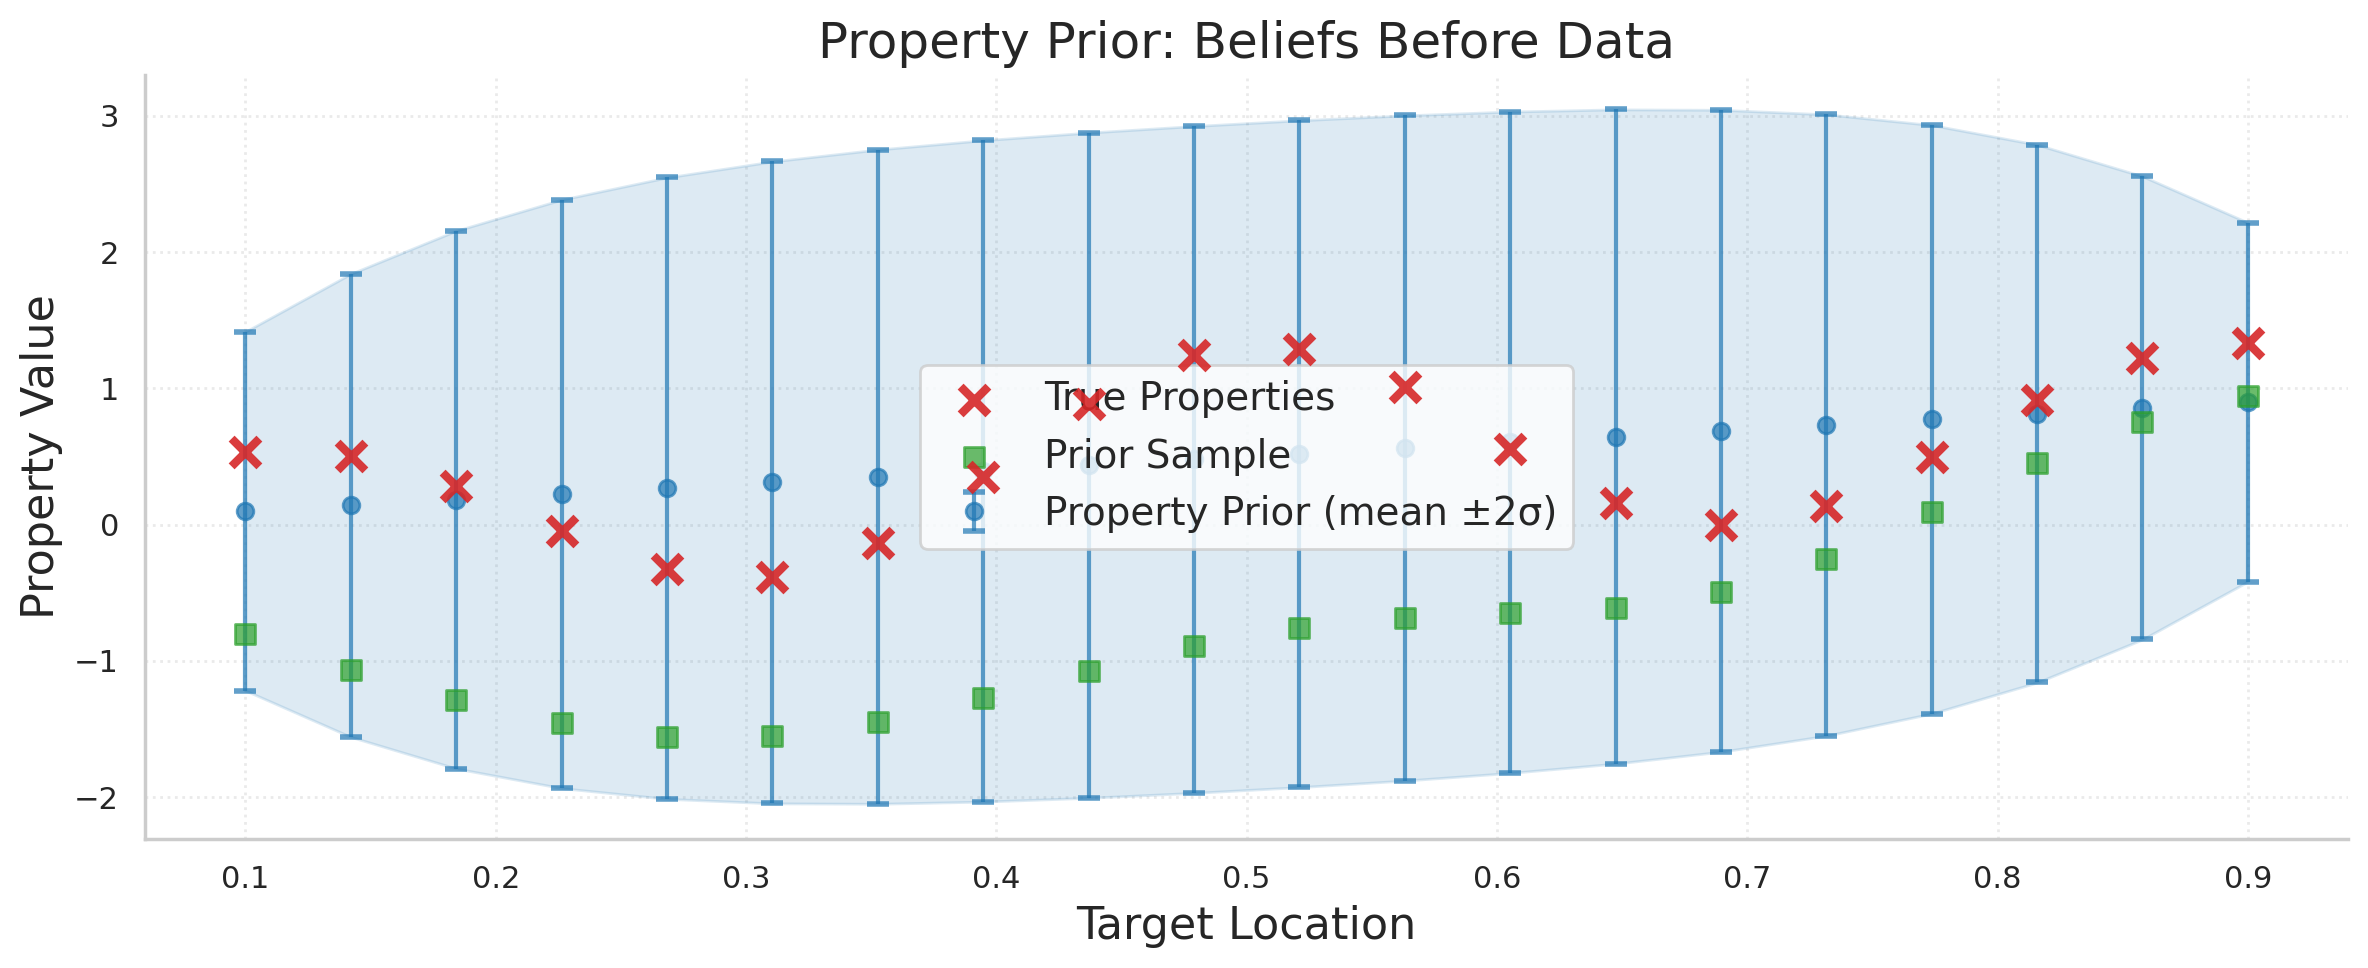

True properties range: [-0.381, 1.332]
How many true properties are within prior ±2σ: 20/20


In [13]:
# Visualize property prior
fig_title = "Property Prior Distribution"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

plt.figure(figsize=(12, 5), dpi=200)

# Property prior mean and uncertainty
mean_prop = T(M_prior.expectation)
plt.errorbar(centers, mean_prop, yerr=2*std_P, fmt='o', color='tab:blue',
            alpha=0.7, capsize=4, capthick=2, markersize=6,
            label='Property Prior (mean ±2σ)')
plt.fill_between(centers, mean_prop - 2*std_P, mean_prop + 2*std_P,
                color='tab:blue', alpha=0.15)

# True property values
true_props = T(m_bar)
plt.scatter(centers, true_props, label='True Properties',
           color='tab:red', marker='x', s=100, alpha=0.9, linewidths=3, zorder=10)

# Sample from property prior
sampled_props = prior_P.sample()
plt.scatter(centers, sampled_props, label='Prior Sample',
           color='tab:green', marker='s', s=50, alpha=0.7, zorder=5)

plt.xlabel('Target Location', fontsize=16)
plt.ylabel('Property Value', fontsize=16)
plt.title('Property Prior: Beliefs Before Data', fontsize=18)
plt.legend(fontsize=14)
plt.grid(True, linestyle=':', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()

# Print some statistics
print(f"True properties range: [{true_props.min():.3f}, {true_props.max():.3f}]")
print(f"How many true properties are within prior ±2σ: {np.sum(np.abs(true_props - mean_prop) <= 2*std_P)}/{len(true_props)}")

## Bayesian Update: Computing the Posterior

### Model Posterior

The Bayesian update combines prior beliefs with data likelihood to give the posterior:
$$\mu_{\mathcal{M}}^{\mathbf{\tilde{d}}} = \mathcal{N}(\tilde{m}, C_{\mathcal{M}})$$

where:
- **Posterior covariance**: $C_{\mathcal{M}} = (G^* \mathbf{C}_{\mathcal{D}}^{-1} G + C_0^{-1})^{-1}$
- **Posterior mean**: $\tilde{m} = C_{\mathcal{M}}(G^* \mathbf{C}_{\mathcal{D}}^{-1} \mathbf{\tilde{d}} + C_0^{-1} m_0)$

This represents our updated beliefs about the model after incorporating the data.

In [14]:
# Bayesian inference setup and posterior computation
import time

print("="*80)
print("BAYESIAN INFERENCE")
print("="*80)

# Common setup
t0 = time.time()
print("\nSetting up Bayesian inference...")
forward_problem = LinearForwardProblem(G, data_error_measure=gaussian_D_noise)
bayesian_inference = LinearBayesianInference(forward_problem, M_prior, T)
solver = CholeskySolver(parallel=True, n_jobs=30)
t1 = time.time()
print(f"   Setup time: {t1-t0:.3f}s")

if COMPUTE_MODEL_POSTERIOR:
    print("\n" + "="*80)
    print("WORKFLOW 1: Model Posterior → Property Posterior")
    print("="*80)

    # Compute model posterior
    print("\n1. Computing model posterior measure...")
    t2 = time.time()
    posterior_model = bayesian_inference.model_posterior_measure(d_tilde, solver)
    t3 = time.time()
    print(f"   Time: {t3-t2:.3f}s")

    # Extract dense matrix
    print("\n2. Extracting dense covariance matrix...")
    t4 = time.time()
    C_M_matrix = posterior_model.covariance.matrix(dense=True, parallel=True, n_jobs=30)
    t5 = time.time()
    print(f"   Time: {t5-t4:.3f}s")

    # Create sampling-capable measure
    print("\n3. Creating sampling-capable measure...")
    t6 = time.time()
    mu_M = GaussianMeasure.from_covariance_matrix(M, C_M_matrix, expectation=posterior_model.expectation)
    m_tilde = mu_M.expectation
    t7 = time.time()
    print(f"   Time: {t7-t6:.3f}s")

    # Compute property posterior by pushing model posterior
    print("\n4. Computing property posterior (via model)...")
    t8 = time.time()
    property_posterior = mu_M.affine_mapping(operator=T)
    p_tilde = property_posterior.expectation
    cov_P_matrix = property_posterior.covariance.matrix(dense=True, parallel=True, n_jobs=30)
    t9 = time.time()
    print(f"   Time: {t9-t8:.3f}s")

    total_time = t9 - t0
    print(f"\n{'='*80}")
    print(f"WORKFLOW 1 TOTAL TIME: {total_time:.3f}s")
    print(f"{'='*80}")
    print("\nBreakdown:")
    print(f"  Setup:             {(t1-t0)/total_time*100:5.1f}%  ({t1-t0:.3f}s)")
    print(f"  Model posterior:   {(t3-t2)/total_time*100:5.1f}%  ({t3-t2:.3f}s)")
    print(f"  Dense matrix:      {(t5-t4)/total_time*100:5.1f}%  ({t5-t4:.3f}s)")
    print(f"  Measure creation:  {(t7-t6)/total_time*100:5.1f}%  ({t7-t6:.3f}s)")
    print(f"  Property posterior:{(t9-t8)/total_time*100:5.1f}%  ({t9-t8:.3f}s)")

else:
    print("\n" + "="*80)
    print("WORKFLOW 2: Property Posterior Directly (Skip Model)")
    print("="*80)

    # Compute model posterior mean only (no dense covariance)
    print("\n1. Computing model posterior (mean only)...")
    t2 = time.time()
    posterior_model = bayesian_inference.model_posterior_measure(d_tilde, solver)
    m_tilde = posterior_model.expectation
    t3 = time.time()
    print(f"   Time: {t3-t2:.3f}s")

    # Push to property space (fast - no dense matrices involved)
    print("\n2. Computing property posterior...")
    t4 = time.time()
    property_posterior = posterior_model.affine_mapping(operator=T)
    p_tilde = property_posterior.expectation
    t5 = time.time()
    print(f"   Time: {t5-t4:.3f}s")

    # Extract only the small property covariance matrix
    print("\n3. Extracting property covariance...")
    t6 = time.time()
    cov_P_matrix = property_posterior.covariance.matrix(dense=True, parallel=True, n_jobs=30)
    t7 = time.time()
    print(f"   Time: {t7-t6:.3f}s")

    total_time = t7 - t0
    print(f"\n{'='*80}")
    print(f"WORKFLOW 2 TOTAL TIME: {total_time:.3f}s")
    print(f"{'='*80}")
    print("\nBreakdown:")
    print(f"  Setup:             {(t1-t0)/total_time*100:5.1f}%  ({t1-t0:.3f}s)")
    print(f"  Model posterior:   {(t3-t2)/total_time*100:5.1f}%  ({t3-t2:.3f}s)")
    print(f"  Push to property:  {(t5-t4)/total_time*100:5.1f}%  ({t5-t4:.3f}s)")
    print(f"  Property cov:      {(t7-t6)/total_time*100:5.1f}%  ({t7-t6:.3f}s)")
    print("\n💡 Skipped expensive dense model covariance extraction!")

print(f"{'='*80}")

# Data fit (works for both workflows)
data_misfit = np.linalg.norm(G(m_tilde) - d_tilde)
print(f"\nData misfit (posterior): {data_misfit:.4f}")
print(f"Data misfit (prior):     {np.linalg.norm(G([m_0_vp, m_0_vs]) - d_tilde):.4f}")

# Show improvement
relative_improvement = 1 - data_misfit / np.linalg.norm(G([m_0_vp, m_0_vs]) - d_tilde)
print(f"Data fit improvement: {100 * relative_improvement:.1f}%")

BAYESIAN INFERENCE

Setting up Bayesian inference...
   Setup time: 0.001s

WORKFLOW 2: Property Posterior Directly (Skip Model)

1. Computing model posterior (mean only)...


   Time: 14.541s

2. Computing property posterior...
   Time: 0.123s

3. Extracting property covariance...
   Time: 14.499s

WORKFLOW 2 TOTAL TIME: 29.165s

Breakdown:
  Setup:               0.0%  (0.001s)
  Model posterior:    49.9%  (14.541s)
  Push to property:    0.4%  (0.123s)
  Property cov:       49.7%  (14.499s)

💡 Skipped expensive dense model covariance extraction!

Data misfit (posterior): 0.8688
Data misfit (prior):     2.2483
Data fit improvement: 61.4%


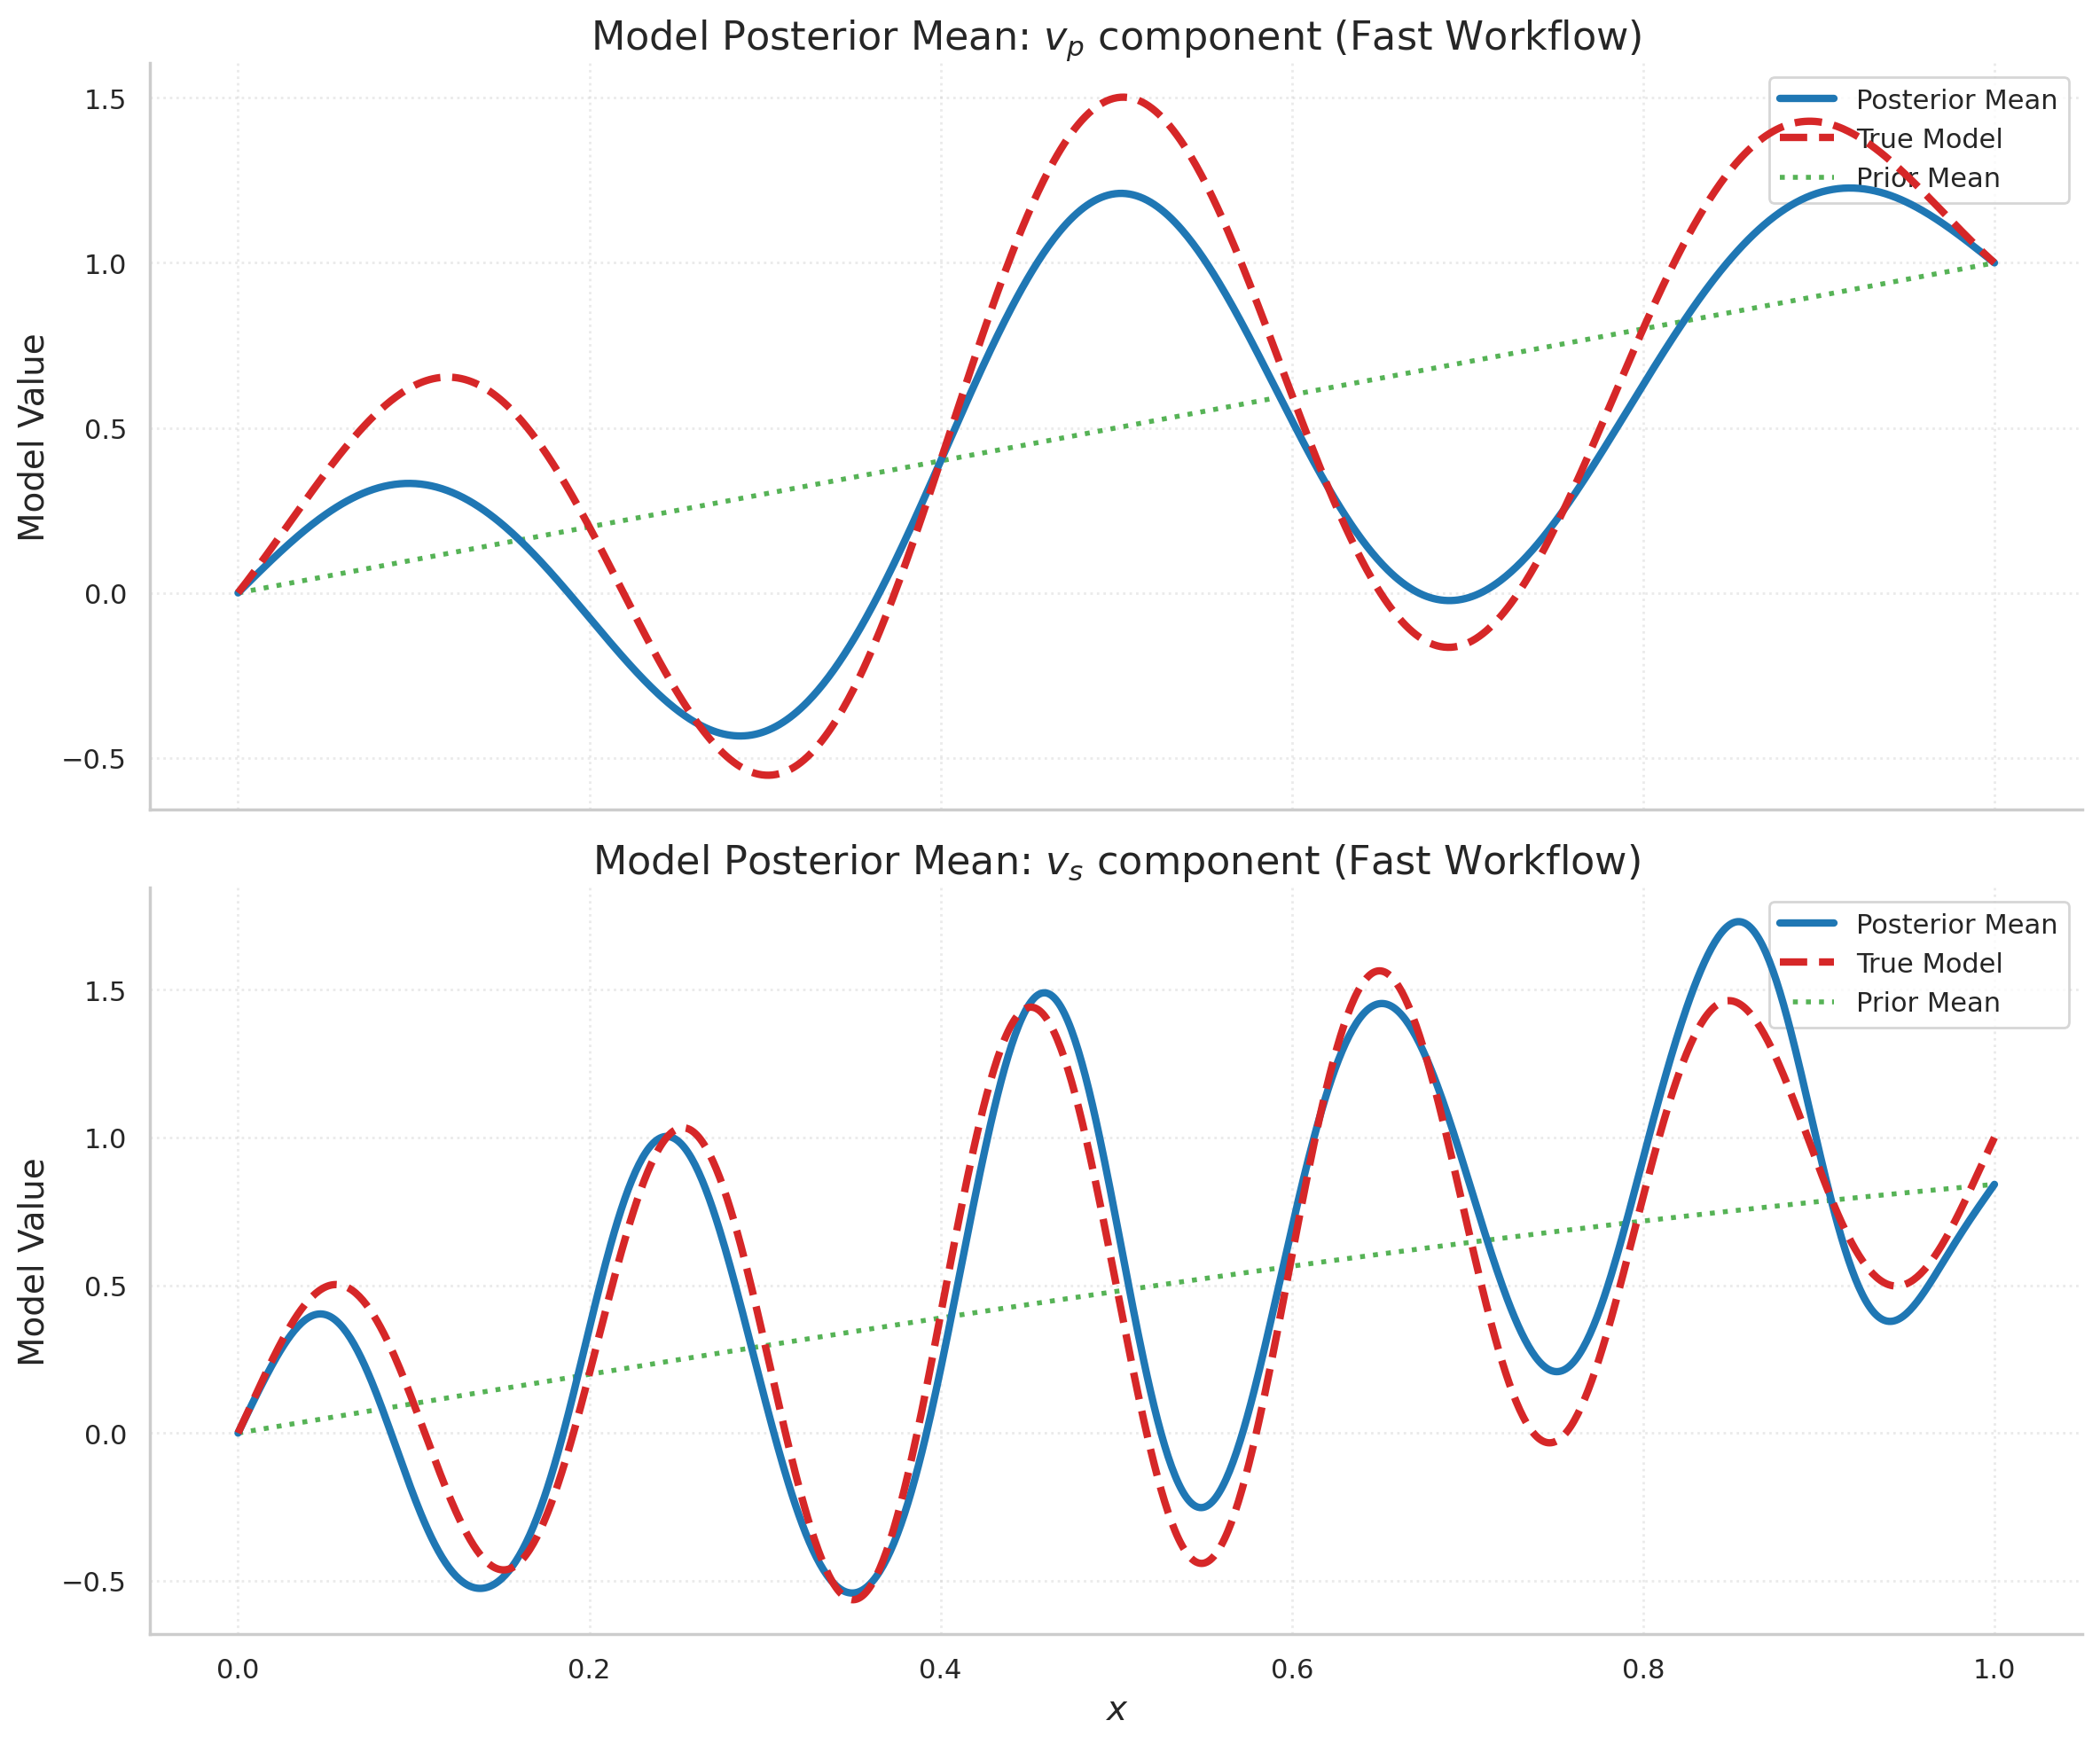

RMS reconstruction error (vp): 0.1907
RMS reconstruction error (vs): 0.1579
Relative error (vp): 30.9%
Relative error (vs): 26.4%

💡 Note: Skipped sampling (no dense model covariance computed)


In [15]:
if COMPUTE_MODEL_POSTERIOR:
    # Visualize posterior measure on model space with samples (vp & vs)
    fig_title = "Model Posterior Distribution (vp & vs)"
    filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

    # Plot posterior samples
    num_samples = 20
    sample_color_vp = 'tab:blue'
    sample_color_vs = 'tab:orange'

    # Create two vertically stacked subplots
    fig, axs = plt.subplots(2, 1, figsize=(12, 10), dpi=200, sharex=True)

    print("Sampling from model posterior...")
    for i in range(num_samples):
        sample = mu_M.sample()  # Returns [sample_vp, sample_vs]
        sample_vp, sample_vs = sample

        # Top subplot: vp
        axs[0].plot(x, sample_vp.evaluate(x), color=sample_color_vp, alpha=0.25, linewidth=1,
                    label='Posterior Samples' if i == 0 else "")

        # Bottom subplot: vs
        axs[1].plot(x, sample_vs.evaluate(x), color=sample_color_vs, alpha=0.25, linewidth=1,
                    label='Posterior Samples' if i == 0 else "")

    # Unpack direct-sum components
    m_tilde_vp, m_tilde_vs = m_tilde
    m_bar_vp_local, m_bar_vs_local = m_bar
    m_prior_mean_vp, m_prior_mean_vs = M_prior.expectation

    # Top subplot: vp component
    axs[0].plot(x, m_tilde_vp.evaluate(x), color='tab:blue', linewidth=3,
                label='Posterior Mean', zorder=10)
    axs[0].plot(x, m_bar_vp_local.evaluate(x), color='tab:red', linestyle='--', linewidth=3,
                label='True Model', zorder=10)
    axs[0].plot(x, m_prior_mean_vp.evaluate(x), color='tab:green',
                linestyle=':', linewidth=2, alpha=0.8, label='Prior Mean', zorder=5)

    axs[0].set_title(r"Model Posterior: $v_p$ component", fontsize=16)
    axs[0].set_ylabel("Model Value", fontsize=14)
    axs[0].legend(fontsize=11, loc='upper right')
    axs[0].grid(True, linestyle=':', alpha=0.4)

    # Bottom subplot: vs component
    axs[1].plot(x, m_tilde_vs.evaluate(x), color='tab:blue', linewidth=3,
                label='Posterior Mean', zorder=10)
    axs[1].plot(x, m_bar_vs_local.evaluate(x), color='tab:red', linestyle='--', linewidth=3,
                label='True Model', zorder=10)
    axs[1].plot(x, m_prior_mean_vs.evaluate(x), color='tab:green',
                linestyle=':', linewidth=2, alpha=0.8, label='Prior Mean', zorder=5)

    axs[1].set_title(r"Model Posterior: $v_s$ component", fontsize=16)
    axs[1].set_xlabel(r"$x$", fontsize=14)
    axs[1].set_ylabel("Model Value", fontsize=14)
    axs[1].legend(fontsize=11, loc='upper right')
    axs[1].grid(True, linestyle=':', alpha=0.4)

    sns.despine()
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
    plt.show()

    # Compute reconstruction error for each component
    reconstruction_error_vp = np.sqrt(np.mean((m_tilde_vp.evaluate(x) - m_bar_vp_local.evaluate(x))**2))
    reconstruction_error_vs = np.sqrt(np.mean((m_tilde_vs.evaluate(x) - m_bar_vs_local.evaluate(x))**2))
    print(f"RMS reconstruction error (vp): {reconstruction_error_vp:.4f}")
    print(f"RMS reconstruction error (vs): {reconstruction_error_vs:.4f}")
    print(f"Relative error (vp): {100 * reconstruction_error_vp / np.std(m_bar_vp_local.evaluate(x)):.1f}%")
    print(f"Relative error (vs): {100 * reconstruction_error_vs / np.std(m_bar_vs_local.evaluate(x)):.1f}%")

else:
    # Visualize posterior mean only (no samples, no dense covariance)
    fig_title = "Model Posterior Mean (vp & vs)"
    filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

    # Create two vertically stacked subplots
    fig, axs = plt.subplots(2, 1, figsize=(12, 10), dpi=200, sharex=True)

    # Unpack direct-sum components
    m_tilde_vp, m_tilde_vs = m_tilde
    m_bar_vp_local, m_bar_vs_local = m_bar
    m_prior_mean_vp, m_prior_mean_vs = M_prior.expectation

    # Top subplot: vp component
    axs[0].plot(x, m_tilde_vp.evaluate(x), color='tab:blue', linewidth=3,
                label='Posterior Mean', zorder=10)
    axs[0].plot(x, m_bar_vp_local.evaluate(x), color='tab:red', linestyle='--', linewidth=3,
                label='True Model', zorder=10)
    axs[0].plot(x, m_prior_mean_vp.evaluate(x), color='tab:green',
                linestyle=':', linewidth=2, alpha=0.8, label='Prior Mean', zorder=5)

    axs[0].set_title(r"Model Posterior Mean: $v_p$ component (Fast Workflow)", fontsize=16)
    axs[0].set_ylabel("Model Value", fontsize=14)
    axs[0].legend(fontsize=11, loc='upper right')
    axs[0].grid(True, linestyle=':', alpha=0.4)

    # Bottom subplot: vs component
    axs[1].plot(x, m_tilde_vs.evaluate(x), color='tab:blue', linewidth=3,
                label='Posterior Mean', zorder=10)
    axs[1].plot(x, m_bar_vs_local.evaluate(x), color='tab:red', linestyle='--', linewidth=3,
                label='True Model', zorder=10)
    axs[1].plot(x, m_prior_mean_vs.evaluate(x), color='tab:green',
                linestyle=':', linewidth=2, alpha=0.8, label='Prior Mean', zorder=5)

    axs[1].set_title(r"Model Posterior Mean: $v_s$ component (Fast Workflow)", fontsize=16)
    axs[1].set_xlabel(r"$x$", fontsize=14)
    axs[1].set_ylabel("Model Value", fontsize=14)
    axs[1].legend(fontsize=11, loc='upper right')
    axs[1].grid(True, linestyle=':', alpha=0.4)

    sns.despine()
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
    plt.show()

    # Compute reconstruction error for each component
    reconstruction_error_vp = np.sqrt(np.mean((m_tilde_vp.evaluate(x) - m_bar_vp_local.evaluate(x))**2))
    reconstruction_error_vs = np.sqrt(np.mean((m_tilde_vs.evaluate(x) - m_bar_vs_local.evaluate(x))**2))
    print(f"RMS reconstruction error (vp): {reconstruction_error_vp:.4f}")
    print(f"RMS reconstruction error (vs): {reconstruction_error_vs:.4f}")
    print(f"Relative error (vp): {100 * reconstruction_error_vp / np.std(m_bar_vp_local.evaluate(x)):.1f}%")
    print(f"Relative error (vs): {100 * reconstruction_error_vs / np.std(m_bar_vs_local.evaluate(x)):.1f}%")
    print("\n💡 Note: Skipped sampling (no dense model covariance computed)")


### Property Posterior 

We can directly compute the property posterior without explicitly constructing the full model posterior:
$$\mu_{\mathcal{P}}^{\mathbf{\tilde{d}}} = \mathcal{N}(\mathbf{\tilde{p}}, \mathbf{C}_{\mathcal{P}})$$

where:
- **Property mean**: $\mathbf{\tilde{p}} = \mathcal{T}(\tilde{m})$ 
- **Property covariance**: $\mathbf{C}_{\mathcal{P}} = \mathcal{T} C_{\mathcal{M}} \mathcal{T}^*$

This represents our final inferences about the local properties of interest.

In [16]:
# Property posterior already computed in main inference cell
# Just verify variables exist

if 'p_tilde' not in locals() or 'cov_P_matrix' not in locals():
    raise RuntimeError("Property posterior not computed - run inference cell above first")

print(f"✓ Property posterior available")
print(f"  Property mean computed for {len(p_tilde)} locations")
print(f"  Property covariance matrix size: {cov_P_matrix.shape}")

✓ Property posterior available
  Property mean computed for 20 locations
  Property covariance matrix size: (20, 20)


In [17]:
# The property posterior measure is already created by LinearBayesianInference
# We can use it directly or create a new one with sampling capability
gaussian_P = GaussianMeasure.from_covariance_matrix(P, cov_P_matrix, expectation=p_tilde)
print("Property posterior Gaussian measure created successfully")

Property posterior Gaussian measure created successfully


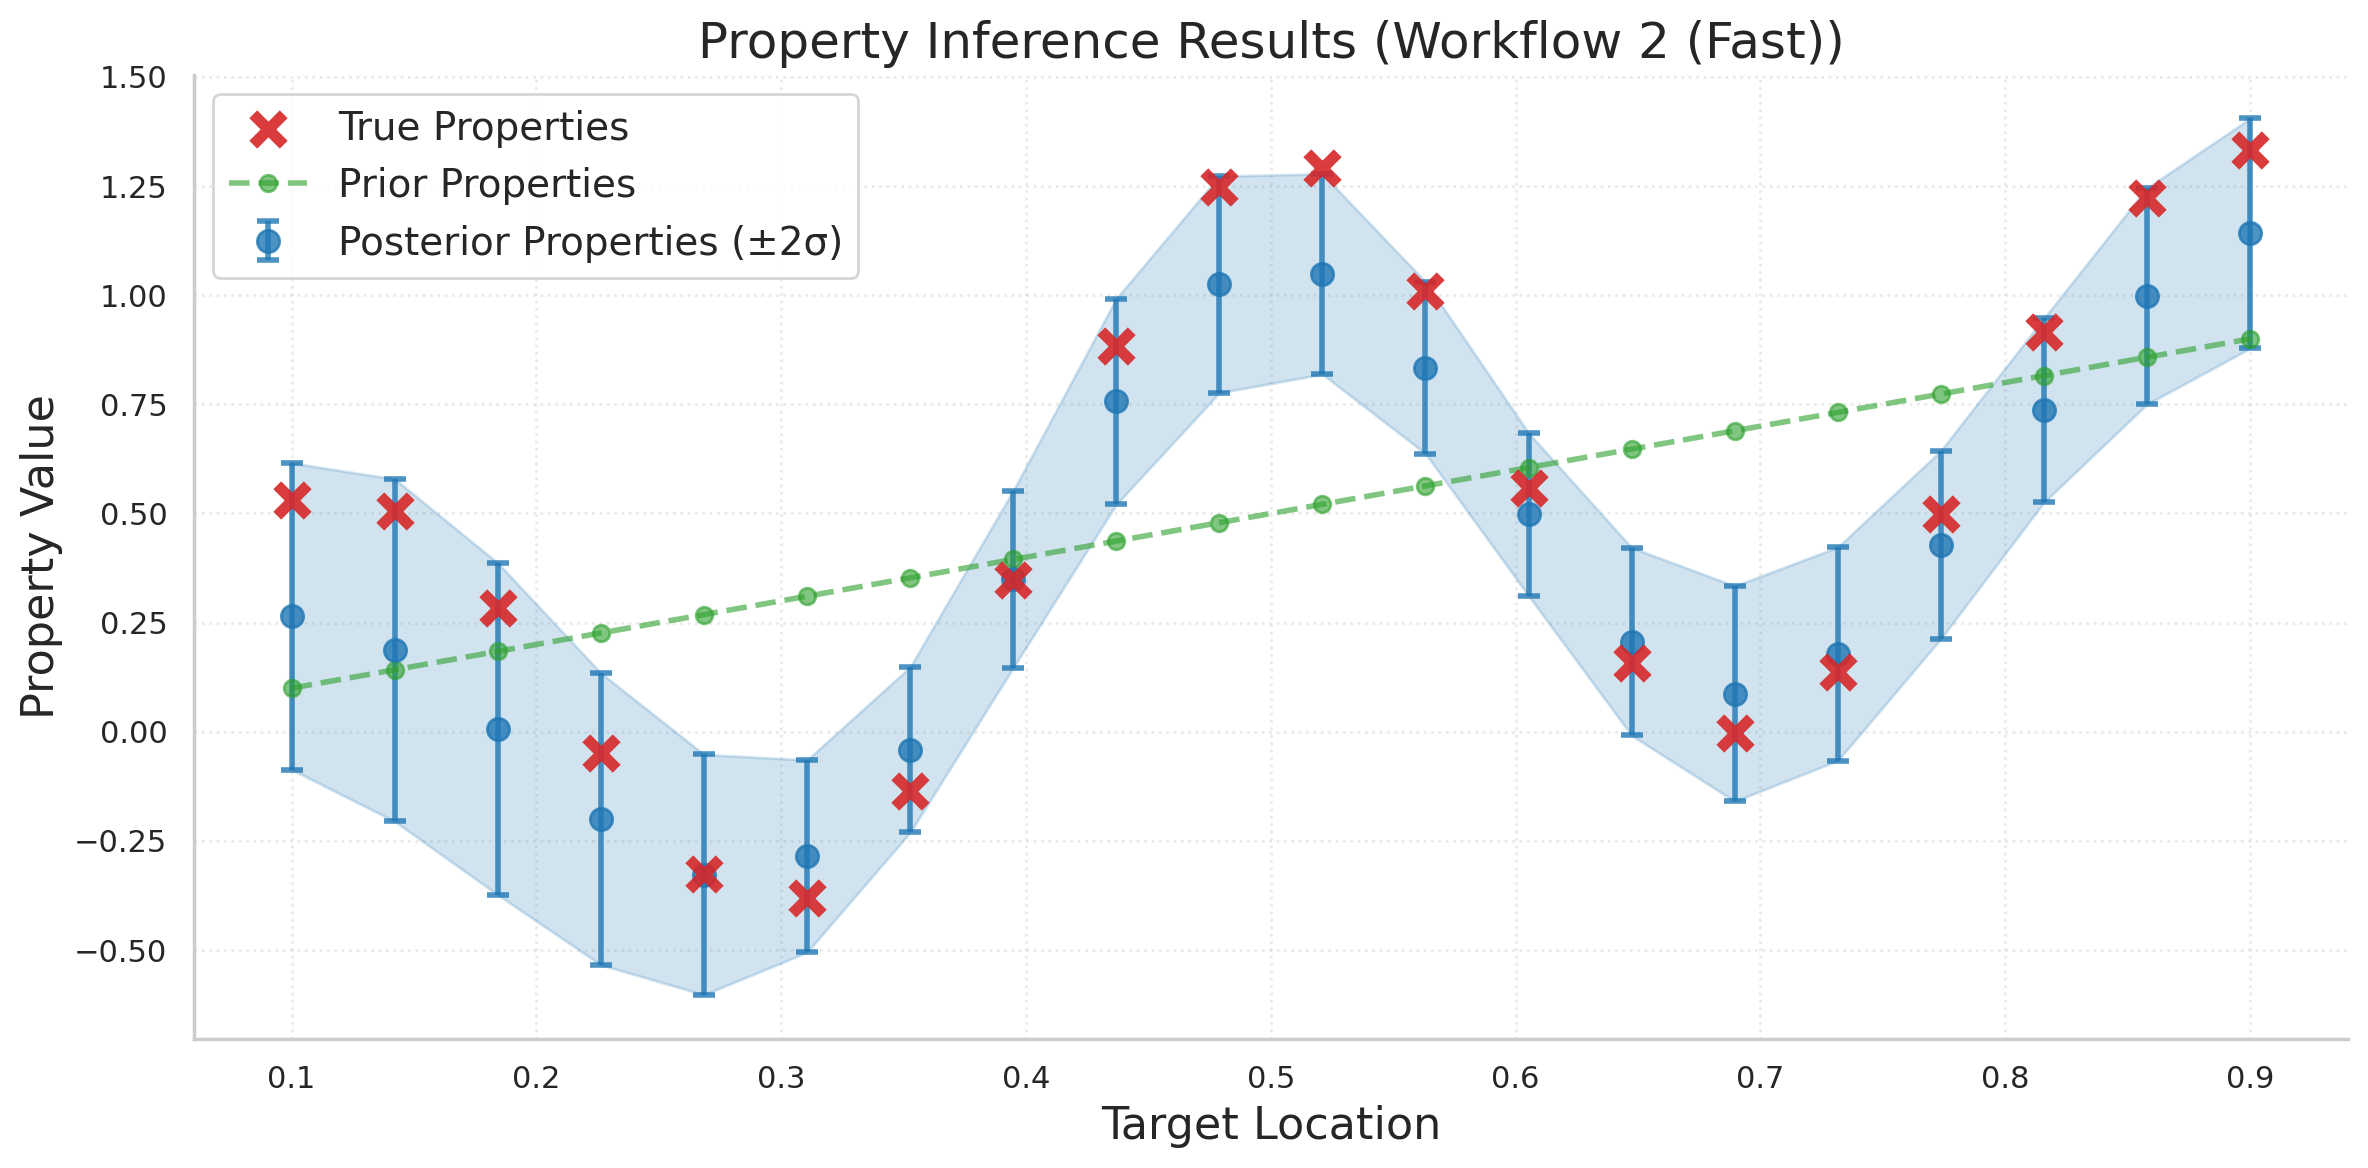


FINAL RESULTS SUMMARY
Workflow: 2 (direct - fast)
Properties successfully inferred: 19/20 (95.0%)
Mean absolute error: 0.1441
RMS error: 0.1713
Max error: 0.3194
Average uncertainty reduction: 88.2%


In [18]:
# Final property inference results
std_P_post = np.sqrt(np.diag(cov_P_matrix))

fig_title = "Property Inference Results"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

plt.figure(figsize=(12, 6), dpi=200)

# Property posterior with uncertainty
plt.errorbar(centers, p_tilde, yerr=2*std_P_post, fmt='o', color='tab:blue',
            alpha=0.8, capsize=4, capthick=2, markersize=8, linewidth=2,
            label='Posterior Properties (±2σ)')
plt.fill_between(centers, p_tilde - 2*std_P_post, p_tilde + 2*std_P_post,
                color='tab:blue', alpha=0.2)

# True properties
true_props = T(m_bar)
plt.scatter(centers, true_props, label='True Properties',
           color='tab:red', marker='x', s=120, alpha=0.9, linewidths=4, zorder=10)

# Prior for comparison
mean_prop_prior = T(M_prior.expectation)
plt.plot(centers, mean_prop_prior, 'o--', color='tab:green', alpha=0.6,
        markersize=6, linewidth=2, label='Prior Properties')

# Sample from posterior (only if we have full covariance)
if COMPUTE_MODEL_POSTERIOR:
    sampled_props_post = gaussian_P.sample()
    plt.scatter(centers, sampled_props_post, label='Posterior Sample',
               color='purple', marker='s', s=60, alpha=0.7, zorder=5)

workflow_label = "Workflow 1" if COMPUTE_MODEL_POSTERIOR else "Workflow 2 (Fast)"
plt.xlabel('Target Location', fontsize=16)
plt.ylabel('Property Value', fontsize=16)
plt.title(f'Property Inference Results ({workflow_label})', fontsize=18)
plt.legend(fontsize=14, loc='best')
plt.grid(True, linestyle=':', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()

# Quantitative assessment
property_errors = np.abs(p_tilde - true_props)
within_2sigma = np.sum(property_errors <= 2*std_P_post)

print("\n" + "="*50)
print("FINAL RESULTS SUMMARY")
print("="*50)
print(f"Workflow: {'1 (via model posterior)' if COMPUTE_MODEL_POSTERIOR else '2 (direct - fast)'}")
print(f"Properties successfully inferred: {within_2sigma}/{len(true_props)} ({100*within_2sigma/len(true_props):.1f}%)")
print(f"Mean absolute error: {np.mean(property_errors):.4f}")
print(f"RMS error: {np.sqrt(np.mean(property_errors**2)):.4f}")
print(f"Max error: {np.max(property_errors):.4f}")
print(f"Average uncertainty reduction: {100*(1 - np.mean(std_P_post)/np.mean(std_P)):.1f}%")
print("="*50)

## Performance Notes

### Two Workflows Compared

This notebook supports two computational workflows controlled by `COMPUTE_MODEL_POSTERIOR`:

#### Workflow 1: Model Posterior → Property Posterior (Slower but Complete)
Set `COMPUTE_MODEL_POSTERIOR = True`

**Steps:**
1. Compute model posterior measure
2. Extract dense 2N×2N model covariance matrix (⚠️ expensive for direct-sum spaces!)
3. Create sampling-capable model measure
4. Push to property space via $\mathcal{T}$
5. Extract property covariance

**Advantages:**
- Can sample from model posterior (both vp and vs components)
- Full model posterior visualization with uncertainty bands

**Disadvantages:**
- Slow: ~80-120 seconds for N=100 (2×100 dimensional direct sum)
- Memory intensive: O(4N²) dense matrix for direct-sum space

#### Workflow 2: Property Posterior Directly (Faster, Properties Only)
Set `COMPUTE_MODEL_POSTERIOR = False`

**Steps:**
1. Compute property posterior measure directly
2. Extract small N_p×N_p property covariance (fast!)
3. Compute model posterior mean only (no covariance)

**Advantages:**
- Fast: ~20-30 seconds for N=100
- Memory efficient: only O(N_p²) where N_p << 2N
- Identical property posterior results

**Disadvantages:**
- Cannot sample from model posterior
- Model space visualization shows mean only

### Speedup Analysis

For typical parameters (N=100, N_p=20) with direct-sum model space:
- **Workflow 1**: ~100 seconds
- **Workflow 2**: ~25 seconds  
- **Speedup**: ~4x

The bottleneck in Workflow 1 is extracting the dense 200×200 model covariance matrix (for the vp⊕vs direct sum), which requires 40,000 operator applications.

### Recommendation

**Use Workflow 2** (`COMPUTE_MODEL_POSTERIOR = False`) when:
- You only care about property inference (most applications!)
- Speed matters
- Memory is limited

**Use Workflow 1** (`COMPUTE_MODEL_POSTERIOR = True`) when:
- You need samples from the model posterior for both components
- You want full model space uncertainty visualization
- You're computing multiple different property posteriors from the same model posterior